# Comparison of distributed hyperparameter optimization techniques using Apache Spark MLlib

## Sylvie Fortier

# Setup

In [ ]:
# CLI configuration:

# token = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()
# dbutils.fs.put('file:///root/.databrickscfg','[DEFAULT]\nhost=https://community.cloud.databricks.com\ntoken =' + token,overwrite=True)

Wrote 97 bytes.
Out[86]: True

In [ ]:
# Import Spark libraries
import pyspark
print('PySpark version', pyspark.__version__)
print('Python version', sc.pythonVer)
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Column, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

# Import MLflow libraries
import mlflow
import mlflow.pyfunc
import mlflow.spark
print('MLflow version', mlflow.version.VERSION)
experiment_name = '/Users/sfortier@mun.ca/Experiment_test'
mlflow.set_experiment(experiment_name)
mlflow.pyspark.ml.autolog(log_models=True)

# Import Hyperopt libraries
import hyperopt
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials, space_eval
print('Hyperopt version', hyperopt.__version__)

# Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from time import time

PySpark version 3.2.1
Python version 3.8
MLflow version 1.24.0
Hyperopt version 0.2.7+db1


Note:<br>
When working directly into databricks notebook, it automatically create a SparkContext

In [ ]:
print('Notebook:',sc.getConf().get('spark.notebook.name'))
print('App_id',sc.getConf().get('spark.app.id'))
print('App_name:',sc.getConf().get('spark.app.name'))
print('Master:',sc.getConf().get('spark.master'))
print('Driver_host',sc.getConf().get('spark.driver.host'))
print('Driver_port',sc.getConf().get('spark.driver.port'))
print('Driver_dir',sc.getConf().get('spark.driver.tempDirectory'))
print('Executer_id:',sc.getConf().get('spark.executor.id'))
print('Executer_dir',sc.getConf().get('spark.executor.tempDirectory'))
print('Cluster_source:',sc.getConf().get('spark.databricks.clusterSource'))
print('Cluster_name:',sc.getConf().get('spark.databricks.clusterUsageTags.clusterName'))
print('Deploy_mode:',sc.getConf().get('spark.submit.deployMode'))
print('Show_progress:',sc.getConf().get('spark.ui.showConsoleProgress'))
print('Eager:',sc.getConf().get('spark.sql.repl.eagerEval.enabled'))
print('Max_rows:',sc.getConf().get('spark.sql.repl.eagerEval.maxNumRows'))

Notebook: None
App_id local-1648205612133
App_name: Databricks Shell
Master: local[8]
Driver_host 10.172.245.19
Driver_port 43935
Driver_dir /local_disk0/tmp
Executer_id: driver
Executer_dir /local_disk0/tmp
Cluster_source: UI
Cluster_name: Ass4
Deploy_mode: None
Show_progress: None
Eager: None
Max_rows: None


In [ ]:
# Initialize SparkSession
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.2.1 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [ ]:
# Show automatically pretty PySpark DF, limit 5
# spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
# spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 5)
# spark.conf.set('spark.ui.showConsoleProgress', True)

# Load datasets

## Taxes

In [ ]:
# Read DS
file_path = "dbfs:/databricks-datasets/data.gov/irs_zip_code_data/data-001/2013_soi_zipcode_agi.csv"

taxes_df = (spark.read 
                 .format('csv') 
                 .option('header', True) 
                 .option('inferSchema', True)
                 .option('nullValue','NULL')
                 .load(file_path))

In [ ]:
# Convert DF --> table
taxes_df.createOrReplaceTempView('taxes_table')

## Markets

In [ ]:
# Read DS
file_path = "dbfs:/databricks-datasets/data.gov/farmers_markets_geographic_data/data-001/market_data.csv"

markets_df = (spark.read 
                   .format('csv') 
                   .option('header', True) 
                   .option('inferSchema', True)
                   .option('nullValue','NULL')
#                    .withColumnRenamed('zip','zipcode')
                   .load(file_path))

In [ ]:
# Convert DF --> table
markets_df.createOrReplaceTempView('markets_table')

# Pre-processing

## Taxes

### Shape

In [ ]:
# get the dimensions of the dataset
print(f'There are {taxes_df.count()} rows and {len(taxes_df.columns)} columns in the dataset')

There are 166740 rows and 114 columns in the dataset


### Dtypes

In [ ]:
taxes_df.printSchema()

root
 |-- STATEFIPS: integer (nullable = true)
 |-- STATE: string (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- agi_stub: integer (nullable = true)
 |-- N1: double (nullable = true)
 |-- MARS1: double (nullable = true)
 |-- MARS2: double (nullable = true)
 |-- MARS4: double (nullable = true)
 |-- PREP: double (nullable = true)
 |-- N2: double (nullable = true)
 |-- NUMDEP: double (nullable = true)
 |-- A00100: double (nullable = true)
 |-- N02650: double (nullable = true)
 |-- A02650: double (nullable = true)
 |-- N00200: double (nullable = true)
 |-- A00200: double (nullable = true)
 |-- N00300: double (nullable = true)
 |-- A00300: double (nullable = true)
 |-- N00600: double (nullable = true)
 |-- A00600: double (nullable = true)
 |-- N00650: double (nullable = true)
 |-- A00650: double (nullable = true)
 |-- N00700: double (nullable = true)
 |-- A00700: double (nullable = true)
 |-- N00900: double (nullable = true)
 |-- A00900: double (nullable = true)
 |-- N01000:

### Head

In [ ]:
# Display first rows
display(taxes_df.limit(5))

STATEFIPS STATE zipcode agi_stub N1 MARS1 MARS2 MARS4 PREP N2 NUMDEP A00100 N02650 A02650 N00200 A00200 N00300 A00300 N00600 A00600 N00650 A00650 N00700 A00700 N00900 A00900 N01000 A01000 N01400 A01400 N01700 A01700 SCHF N02300 A02300 N02500 A02500 N26270 A26270 N02900 A02900 N03220 A03220 N03300 A03300 N03270 A03270 N03150 A03150 N03210 A03210 N03230 A03230 N03240 A03240 N04470 A04470 A00101 N18425 A18425 N18450 A18450 N18500 A18500 N18300 A18300 N19300 A19300 N19700 A19700 N04800 A04800 N05800 A05800 N09600 A09600 N07100 A07100 N07300 A07300 N07180 A07180 N07230 A07230 N07240 A07240 N07220 A07220 N07260 A07260 N09400 A09400 N10600 A10600 N59660 A59660 N59720 A59720 N11070 A11070 N10960 A10960 N06500 A06500 N10300 A10300 N85330 A85330 N85300 A85300 N11901 A11901 N11902 A11902 1 AL 0 1 870380.0 488030.0 122290.0 247000.0 500770.0 1452580.0 571240.0 1.1255896E7 870380.0 1.1444868E7 700700.0 8889326.0 103290.0 77952.0 46870.0 75071.0 40890.0 47416.0 15650.0 6538.0 146240.0 824487.0 37970.0 23583.0 38400.0 221790.0 111060.0 1066291.0 8800.0 49720.0 187559.0 35370.0 62791.0 8980.0 10323.0 155190.0 186574.0 3300.0 747.0 140.0 487.0 8950.0 33584.0 2540.0 6212.0 20760.0 17533.0 5900.0 16956.0 30.0 2.0 57090.0 794815.0 884758.0 23440.0 22991.0 25940.0 20686.0 29140.0 25144.0 54970.0 84317.0 27140.0 151005.0 42500.0 111909.0 338560.0 1874627.0 333040.0 196535.0 0.0 0.0 108740.0 37220.0 2400.0 56.0 8850.0 2899.0 33010.0 16969.0 32080.0 5457.0 33530.0 10160.0 2650.0 677.0 117420.0 152943.0 807980.0 2277816.0 399710.0 1174659.0 371280.0 1057938.0 258200.0 327115.0 80350.0 76412.0 255750.0 159189.0 371450.0 318777.0 0.0 0.0 0.0 0.0 59580.0 44367.0 767170.0 2005593.0 1 AL 0 2 490960.0 195840.0 155230.0 125280.0 286130.0 1027850.0 383240.0 1.7632481E7 490960.0 1.7810952E7 427730.0 1.4501798E7 97400.0 81216.0 42440.0 92536.0 37100.0 61479.0 58830.0 29891.0 61400.0 252768.0 32710.0 54639.0 34860.0 320115.0 101580.0 1764445.0 8890.0 23590.0 84183.0 87130.0 542763.0 10690.0 49672.0 95190.0 177106.0 12310.0 2968.0 240.0 975.0 6870.0 31725.0 6350.0 20932.0 36070.0 36540.0 2360.0 5915.0 60.0 35.0 115520.0 1717953.0 4390768.0 83910.0 140609.0 25240.0 32077.0 77400.0 61241.0 113360.0 262971.0 72830.0 405101.0 94310.0 341396.0 470370.0 8602452.0 468160.0 1038975.0 0.0 0.0 217760.0 194669.0 6030.0 262.0 28850.0 16248.0 46050.0 47721.0 65150.0 12104.0 124900.0 110801.0 12820.0 4944.0 37210.0 77948.0 480870.0 2041535.0 132780.0 259313.0 112050.0 223466.0 104610.0 156274.0 37270.0 34254.0 367070.0 844185.0 386570.0 935430.0 0.0 0.0 0.0 0.0 65850.0 94281.0 418070.0 1192755.0 1 AL 0 3 258810.0 72710.0 146880.0 32860.0 157670.0 594910.0 189340.0 1.5916085E7 258810.0 1.6070153E7 223860.0 1.2289284E7 86850.0 80627.0 40800.0 118256.0 36250.0 81316.0 68480.0 42607.0 39840.0 259836.0 32420.0 84137.0 27970.0 348231.0 72490.0 1727323.0 7940.0 11640.0 45125.0 59580.0 849865.0 10940.0 94229.0 68820.0 151722.0 9550.0 2369.0 190.0 1100.0 4800.0 24606.0 5070.0 20023.0 26750.0 26173.0 2290.0 5165.0 110.0 171.0 105460.0 1797725.0 6537061.0 85350.0 216962.0 16720.0 25271.0 85670.0 78046.0 104930.0 347945.0 79910.0 498801.0 90350.0 396144.0 257690.0 1.0164831E7 257080.0 1401115.0 100.0 58.0 115430.0 170908.0 7860.0 542.0 18540.0 9741.0 25080.0 31702.0 13300.0 2074.0 77900.0 118242.0 10740.0 4167.0 26610.0 65373.0 255340.0 1749879.0 310.0 25.0 520.0 47.0 10470.0 13259.0 18980.0 17402.0 245810.0 1229923.0 249040.0 1310745.0 0.0 0.0 0.0 0.0 58810.0 125566.0 194360.0 552938.0 1 AL 0 4 163290.0 24860.0 126480.0 9790.0 98920.0 424160.0 134370.0 1.4161207E7 163290.0 1.4288572E7 143290.0 1.0773848E7 72130.0 71086.0 36370.0 120329.0 32710.0 84330.0 62060.0 44250.0 27380.0 214668.0 28960.0 105947.0 21820.0 357541.0 52290.0 1537085.0 6240.0 6550.0 25907.0 39400.0 752960.0 10280.0 117239.0 48480.0 123525.0 9130.0 2478.0 270.0 2241.0 3310.0 18757.0 3780.0 17325.0 17920.0 20191.0 830.0 1736.0 170.0 303.0 86180.0 1662813.0 7527384.0 73820.0 256947.0 10260.0 18251.0 77040.0 80626.0 86010.0

In [ ]:
%sql
SELECT *
FROM taxes_table
LIMIT 5

STATEFIPS STATE zipcode agi_stub N1 MARS1 MARS2 MARS4 PREP N2 NUMDEP A00100 N02650 A02650 N00200 A00200 N00300 A00300 N00600 A00600 N00650 A00650 N00700 A00700 N00900 A00900 N01000 A01000 N01400 A01400 N01700 A01700 SCHF N02300 A02300 N02500 A02500 N26270 A26270 N02900 A02900 N03220 A03220 N03300 A03300 N03270 A03270 N03150 A03150 N03210 A03210 N03230 A03230 N03240 A03240 N04470 A04470 A00101 N18425 A18425 N18450 A18450 N18500 A18500 N18300 A18300 N19300 A19300 N19700 A19700 N04800 A04800 N05800 A05800 N09600 A09600 N07100 A07100 N07300 A07300 N07180 A07180 N07230 A07230 N07240 A07240 N07220 A07220 N07260 A07260 N09400 A09400 N10600 A10600 N59660 A59660 N59720 A59720 N11070 A11070 N10960 A10960 N06500 A06500 N10300 A10300 N85330 A85330 N85300 A85300 N11901 A11901 N11902 A11902 1 AL 0 1 870380.0 488030.0 122290.0 247000.0 500770.0 1452580.0 571240.0 1.1255896E7 870380.0 1.1444868E7 700700.0 8889326.0 103290.0 77952.0 46870.0 75071.0 40890.0 47416.0 15650.0 6538.0 146240.0 824487.0 37970.0 23583.0 38400.0 221790.0 111060.0 1066291.0 8800.0 49720.0 187559.0 35370.0 62791.0 8980.0 10323.0 155190.0 186574.0 3300.0 747.0 140.0 487.0 8950.0 33584.0 2540.0 6212.0 20760.0 17533.0 5900.0 16956.0 30.0 2.0 57090.0 794815.0 884758.0 23440.0 22991.0 25940.0 20686.0 29140.0 25144.0 54970.0 84317.0 27140.0 151005.0 42500.0 111909.0 338560.0 1874627.0 333040.0 196535.0 0.0 0.0 108740.0 37220.0 2400.0 56.0 8850.0 2899.0 33010.0 16969.0 32080.0 5457.0 33530.0 10160.0 2650.0 677.0 117420.0 152943.0 807980.0 2277816.0 399710.0 1174659.0 371280.0 1057938.0 258200.0 327115.0 80350.0 76412.0 255750.0 159189.0 371450.0 318777.0 0.0 0.0 0.0 0.0 59580.0 44367.0 767170.0 2005593.0 1 AL 0 2 490960.0 195840.0 155230.0 125280.0 286130.0 1027850.0 383240.0 1.7632481E7 490960.0 1.7810952E7 427730.0 1.4501798E7 97400.0 81216.0 42440.0 92536.0 37100.0 61479.0 58830.0 29891.0 61400.0 252768.0 32710.0 54639.0 34860.0 320115.0 101580.0 1764445.0 8890.0 23590.0 84183.0 87130.0 542763.0 10690.0 49672.0 95190.0 177106.0 12310.0 2968.0 240.0 975.0 6870.0 31725.0 6350.0 20932.0 36070.0 36540.0 2360.0 5915.0 60.0 35.0 115520.0 1717953.0 4390768.0 83910.0 140609.0 25240.0 32077.0 77400.0 61241.0 113360.0 262971.0 72830.0 405101.0 94310.0 341396.0 470370.0 8602452.0 468160.0 1038975.0 0.0 0.0 217760.0 194669.0 6030.0 262.0 28850.0 16248.0 46050.0 47721.0 65150.0 12104.0 124900.0 110801.0 12820.0 4944.0 37210.0 77948.0 480870.0 2041535.0 132780.0 259313.0 112050.0 223466.0 104610.0 156274.0 37270.0 34254.0 367070.0 844185.0 386570.0 935430.0 0.0 0.0 0.0 0.0 65850.0 94281.0 418070.0 1192755.0 1 AL 0 3 258810.0 72710.0 146880.0 32860.0 157670.0 594910.0 189340.0 1.5916085E7 258810.0 1.6070153E7 223860.0 1.2289284E7 86850.0 80627.0 40800.0 118256.0 36250.0 81316.0 68480.0 42607.0 39840.0 259836.0 32420.0 84137.0 27970.0 348231.0 72490.0 1727323.0 7940.0 11640.0 45125.0 59580.0 849865.0 10940.0 94229.0 68820.0 151722.0 9550.0 2369.0 190.0 1100.0 4800.0 24606.0 5070.0 20023.0 26750.0 26173.0 2290.0 5165.0 110.0 171.0 105460.0 1797725.0 6537061.0 85350.0 216962.0 16720.0 25271.0 85670.0 78046.0 104930.0 347945.0 79910.0 498801.0 90350.0 396144.0 257690.0 1.0164831E7 257080.0 1401115.0 100.0 58.0 115430.0 170908.0 7860.0 542.0 18540.0 9741.0 25080.0 31702.0 13300.0 2074.0 77900.0 118242.0 10740.0 4167.0 26610.0 65373.0 255340.0 1749879.0 310.0 25.0 520.0 47.0 10470.0 13259.0 18980.0 17402.0 245810.0 1229923.0 249040.0 1310745.0 0.0 0.0 0.0 0.0 58810.0 125566.0 194360.0 552938.0 1 AL 0 4 163290.0 24860.0 126480.0 9790.0 98920.0 424160.0 134370.0 1.4161207E7 163290.0 1.4288572E7 143290.0 1.0773848E7 72130.0 71086.0 36370.0 120329.0 32710.0 84330.0 62060.0 44250.0 27380.0 214668.0 28960.0 105947.0 21820.0 357541.0 52290.0 1537085.0 6240.0 6550.0 25907.0 39400.0 752960.0 10280.0 117239.0 48480.0 123525.0 9130.0 2478.0 270.0 2241.0 3310.0 18757.0 3780.0 17325.0 17920.0 20191.0 830.0 1736.0 170.0 303.0 86180.0 1662813.0 7527384.0 73820.0 256947.0 10260.0 18251.0 77040.0 80626.0 86010.0

### Column names

In [ ]:
taxes_df.columns

Out[31]: ['STATEFIPS',
 'STATE',
 'zipcode',
 'agi_stub',
 'N1',
 'MARS1',
 'MARS2',
 'MARS4',
 'PREP',
 'N2',
 'NUMDEP',
 'A00100',
 'N02650',
 'A02650',
 'N00200',
 'A00200',
 'N00300',
 'A00300',
 'N00600',
 'A00600',
 'N00650',
 'A00650',
 'N00700',
 'A00700',
 'N00900',
 'A00900',
 'N01000',
 'A01000',
 'N01400',
 'A01400',
 'N01700',
 'A01700',
 'SCHF',
 'N02300',
 'A02300',
 'N02500',
 'A02500',
 'N26270',
 'A26270',
 'N02900',
 'A02900',
 'N03220',
 'A03220',
 'N03300',
 'A03300',
 'N03270',
 'A03270',
 'N03150',
 'A03150',
 'N03210',
 'A03210',
 'N03230',
 'A03230',
 'N03240',
 'A03240',
 'N04470',
 'A04470',
 'A00101',
 'N18425',
 'A18425',
 'N18450',
 'A18450',
 'N18500',
 'A18500',
 'N18300',
 'A18300',
 'N19300',
 'A19300',
 'N19700',
 'A19700',
 'N04800',
 'A04800',
 'N05800',
 'A05800',
 'N09600',
 'A09600',
 'N07100',
 'A07100',
 'N07300',
 'A07300',
 'N07180',
 'A07180',
 'N07230',
 'A07230',
 'N07240',
 'A07240',
 'N07220',
 'A07220',
 'N07260',
 'A07260',
 'N09400',


### Cleanup
Select only specify columns, cleanup zipcode, change some dtypes, and rename columns

In [ ]:
%sql 
CREATE OR REPLACE TABLE cleaned_taxes AS
   SELECT state, 
          int(zipcode / 10) AS zip, 
          int(mars2) AS joint_returns, 
          A02650 AS total_income_amount,
          a01000 + a00900 AS combo
  FROM taxes_table

com.databricks.backend.common.rpc.DatabricksExceptions$SQLExecutionException: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.jobAbortedError(QueryExecutionErrors.scala:603)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:359)
	at com.databricks.sql.transaction.tahoe.files.TransactionalWriteEdge.$anonfun$writeFiles$8(TransactionalWriteEdge.scala:416)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withCustomExecutionEnv$6(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:342)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withCustomExecutionEnv$1(SQLExecution.scala:153)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:852)
	at org.apache.spark.sql.execution.SQLExecution$.withCustomExecutionEnv(SQLExecution.scala:115)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:292)
	at com.databricks.sql.transaction.tahoe.files.TransactionalWriteEdge.$anonfun$writeFiles$1(TransactionalWriteEdge.scala:354)
	at com.databricks.sql.transaction.tahoe.metering.DeltaLogging.withOperationTypeTag(DeltaLogging.scala:156)
	at com.databricks.sql.transaction.tahoe.metering.DeltaLogging.withOperationTypeTag$(DeltaLogging.scala:143)
	at com.databricks.sql.transaction.tahoe.OptimisticTransaction.withOperationTypeTag(OptimisticTransaction.scala:104)
	at com.databricks.sql.transaction.tahoe.metering.DeltaLogging.$anonfun$recordDeltaOperation$6(DeltaLogging.scala:121)
	at com.databricks.spark.util.FrameProfiler$.record(FrameProfiler.scala:80)
	at com.databricks.sql.transaction.tahoe.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:171)
	at com.databricks.sql.transaction.tahoe.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:169)
	at com.databricks.sql.transaction.tahoe.OptimisticTransaction.recordFrameProfile(OptimisticTransaction.scala:104)
	at com.databricks.sql.transaction.tahoe.metering.DeltaLogging.$anonfun$recordDeltaOperation$5(DeltaLogging.scala:120)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:366)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:460)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:480)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$2(UsageLogging.scala:232)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:94)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:230)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:212)
	at com.databricks.spark.util.PublicDBLogging.withAttributionContext(DatabricksSparkUsageLogger.scala:20)
	at com.databricks.logging.UsageLogging.withAttributionTags(UsageLogging.scala:276)
	at com.databricks.logging.UsageLogging.withAttributionTags$(UsageLogging.scala:261)
	at com.databricks.spark.util.PublicDBLogging.withAttributionTags(DatabricksSparkUsageLogger.scala:20)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags(UsageLogging.scala:455)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags$(UsageLogging.scala:375)
	at com.databricks.spark.util.PublicDBLogging.recordOperationWithResultTags(DatabricksSparkUsageLogger.scala:20)
	at com.databricks.logging.UsageLogging.recordOperation(UsageLogging.scala:366)
	at com.databricks.logging.UsageLogging.recordOperation$(UsageLogging.scala:338)
	at com.databricks.spark.util.PublicDBLogging.recordOperation(DatabricksSparkUsageLogger.scala:20)
	at com.databricks.spark.util.PublicDBLogging.recordOperation0(DatabricksSparkUsageLogger.scala:57)
	at com.databricks.spark.util.DatabricksS

In [ ]:
# Convert table --> DF
cleanedTaxes = spark.table('cleaned_taxes')
# # Check type
print(type(cleanedTaxes))
# # Check dtypes
cleanedTaxes.printSchema()
# # Display sum of each column by zipcode
# display(cleanedTaxes.groupBy('state') \
#             .agg(np.round(np.mean('total_income_amount'))) \
#             .withColumnRenamed('round(avg(total_income_amount), 0)', 'Mean_income')    )                 

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
<command-3761577802430432> in <module>
      1 # Convert table --> DF
----> 2 cleanedTaxes = spark.table('cleaned_taxes2')
      3 # # Check type
      4 print(type(cleanedTaxes))
      5 # # Check dtypes

/databricks/spark/python/pyspark/sql/session.py in table(self, tableName)
    793         True
    794         """
--> 795         return DataFrame(self._jsparkSession.table(tableName), self._wrapped)
    796 
    797     @property

/databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/java_gateway.py in __call__(self, *args)
   1302 
   1303         answer = self.gateway_client.send_command(command)
-> 1304         return_value = get_return_value(
   1305             answer, self.gateway_client, self.target_id, self.name)
   1306 

/databricks/spark/python/pyspark/sql/utils.py in deco(*a, **kw)
    121                 # Hide where 

In [ ]:
# Display sum of each column by zipcode
summedTaxes = (cleanedTaxes.groupBy('zip') 
                           .sum())

# Row count
print(f'The are {summedTaxes.count()} rows')
# Display results
display(summedTaxes)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-3761577802430452> in <module>
      1 # Display sum of each column by zipcode
----> 2 summedTaxes = (cleanedTaxes.groupBy('zip') 
      3                            .sum())
      4 
      5 # Row count

NameError: name 'cleanedTaxes' is not defined

### Cache

In [ ]:
summedTaxes.cache()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-3761577802430434> in <module>
----> 1 summedTaxes.cache()

NameError: name 'summedTaxes' is not defined

### Describe

In [ ]:
summedTaxes.describe().toPandas().transpose()

0 
 1 
 2 
 3 
 4 
 
 
 
 
 summary 
 count 
 mean 
 stddev 
 min 
 max 
 
 
 zip 
 5742 
 4877.050330895158 
 2755.4352203452927 
 0 
 9999 
 
 
 sum(zip) 
 5742 
 141852.03761755486 
 117727.30685571216 
 0 
 3059694 
 
 
 sum(joint_returns) 
 5742 
 18432.391152908393 
 697976.0658550117 
 30 
 52885400 
 
 
 sum(total_income_amount) 
 5742 
 3230275.870776733 
 1.2241583009814014E8 
 3766.0 
 9.274122025E9 
 
 
 sum(combo) 
 5742 
 247158.64576802508 
 9372066.17141698 
 -5.0 
 7.09592472E8

## Markets

### Shape

In [ ]:
# get the dimensions of the dataset
print(f'There are {markets_df.count()} rows and {len(markets_df.columns)} columns in the dataset')

There are 8518 rows and 59 columns in the dataset


### Dtypes

In [ ]:
markets_df.printSchema()

root
 |-- FMID: integer (nullable = true)
 |-- MarketName: string (nullable = true)
 |-- Website: string (nullable = true)
 |-- Facebook: string (nullable = true)
 |-- Twitter: string (nullable = true)
 |-- Youtube: string (nullable = true)
 |-- OtherMedia: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- Season1Date: string (nullable = true)
 |-- Season1Time: string (nullable = true)
 |-- Season2Date: string (nullable = true)
 |-- Season2Time: string (nullable = true)
 |-- Season3Date: string (nullable = true)
 |-- Season3Time: string (nullable = true)
 |-- Season4Date: string (nullable = true)
 |-- Season4Time: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Credit: string (nullable = true)
 |-- WIC: string (nullable = true)
 |-- WICca

### Head

In [ ]:
# Display first rows
display(markets_df.limit(5))

FMID MarketName Website Facebook Twitter Youtube OtherMedia street city County State zip Season1Date Season1Time Season2Date Season2Time Season3Date Season3Time Season4Date Season4Time x y Location Credit WIC WICcash SFMNP SNAP Organic Bakedgoods Cheese Crafts Flowers Eggs Seafood Herbs Vegetables Honey Jams Maple Meat Nursery Nuts Plants Poultry Prepared Soap Trees Wine Coffee Beans Fruits Grains Juices Mushrooms PetFood Tofu WildHarvested updateTime 1000618 100-Mile Market http://www.peoplesfoodco-op.org/ null null null null 507 Harrison Street Kalamazoo Kalamazoo Michigan 49007 05/07/2014 to 10/29/2014 Wed: 3:00 PM-7:00 PM; null null null null null null -85.57502 42.29596 Private business parking lot Y Y N Y Y Y Y Y N Y Y N Y Y Y Y Y Y N N Y Y Y Y N N Y N Y N N Y N N Y 4/24/2014 6:22:51 PM 1009364 106 S. Main Street Farmers Market http://thetownofsixmile.wordpress.com/ null null null null 106 S. Main Street Six Mile null South Carolina 29682 null null null null null null null null -82.8187 34.8042 null Y N N N N - N N N N N N N N N N N N N N N N N N N N N N N N N N N N N 2013 1010691 10th Steet Community Farmers Market null null null null http://agrimissouri.com/mo-grown/grodetail.php?type=mo-grown&ID=275 10th Street and Poplar Lamar Barton Missouri 64759 04/02/2014 to 11/30/2014 Wed: 3:00 PM-6:00 PM;Sat: 8:00 AM-1:00 PM; null null null null null null -94.2746191 37.495628 null Y N N N N - Y N Y N Y N Y Y Y Y N Y N N Y Y Y Y N N N N Y N N N N N N 10/28/2014 9:49:46 AM 1002454 112st Madison Avenue null null null null null 112th Madison Avenue New York New York New York 10029 July to November Tue:8:00 am - 5:00 pm;Sat:8:00 am - 8:00 pm; null null null null null null -73.9493 40.7939 Private business parking lot N N Y Y N - Y N Y Y N N Y Y Y Y N N N Y N N Y Y N N N N N N N N N N N 3/1/2012 10:38:22 AM 1011100 12 South Farmers Market http://www.12southfarmersmarket.com 12_South_Farmers_Market @12southfrmsmkt null @12southfrmsmkt 3000 Granny White Pike Nashville Davidson Tennessee 37204 05/05/2015 to 10/27/2015 Tue: 3:30 PM-6:30 PM; null null null null null null -86.790709 36.11837 null Y N N N Y Y Y Y N Y Y N Y Y Y Y Y Y N N N Y Y Y N N Y N Y N Y Y Y N N 5/1/2015 10:40:56 AM

### Column names

In [ ]:
markets_df.columns

Out[106]: ['FMID',
 'MarketName',
 'Website',
 'Facebook',
 'Twitter',
 'Youtube',
 'OtherMedia',
 'street',
 'city',
 'County',
 'State',
 'zip',
 'Season1Date',
 'Season1Time',
 'Season2Date',
 'Season2Time',
 'Season3Date',
 'Season3Time',
 'Season4Date',
 'Season4Time',
 'x',
 'y',
 'Location',
 'Credit',
 'WIC',
 'WICcash',
 'SFMNP',
 'SNAP',
 'Organic',
 'Bakedgoods',
 'Cheese',
 'Crafts',
 'Flowers',
 'Eggs',
 'Seafood',
 'Herbs',
 'Vegetables',
 'Honey',
 'Jams',
 'Maple',
 'Meat',
 'Nursery',
 'Nuts',
 'Plants',
 'Poultry',
 'Prepared',
 'Soap',
 'Trees',
 'Wine',
 'Coffee',
 'Beans',
 'Fruits',
 'Grains',
 'Juices',
 'Mushrooms',
 'PetFood',
 'Tofu',
 'WildHarvested',
 'updateTime']

### Cleanup
Select only specify columns, cleanup zipcode, change some dtypes, and rename columns

In [ ]:
# Value count for each zipcode
target_markets = (markets_df
                  .selectExpr("*", 'int(zip / 10) AS zipcode')
                  .groupBy('zipcode')
                  .count()
                  .selectExpr('double(count) AS target', 'zipcode AS zipcodes')) # double b/c it's needed later???
# Check dtypes
target_markets.printSchema()
# Row count
print(f'The target variable has {target_markets.count()} rows')
# Display results
target_markets

root
 |-- target: double (nullable = false)
 |-- zipcodes: integer (nullable = true)

The target variable has 3589 rows


target zipcodes 
 5.0 4900 
 2.0 7240 
 8.0 4818 
 1.0 9852 
 2.0 5300 
 
only showing top 5 rows

**String Index**

In [ ]:
# Replace Yes by value 1 and No by value 0
markets_df = markets_df.replace('Y','1')
markets_df = markets_df.replace('N','0')

**Combine Columns**

In [ ]:
# Prepared_food
markets_df = markets_df.withColumn('Prepared_foods', markets_df.Bakedgoods + markets_df.Prepared)
# Garden
markets_df = markets_df.withColumn('Garden', markets_df.Flowers + markets_df.Plants + markets_df.Trees)
# Drinks
markets_df = markets_df.withColumn('Drinks', markets_df.Coffee + markets_df.Wine + markets_df.Juices)
# Fruits & veggies
markets_df = markets_df.withColumn('F_V', markets_df.Fruits + markets_df.Vegetables)
# Proteins
markets_df = markets_df.withColumn('Proteins', markets_df.Meat + markets_df.Seafood + markets_df.Poultry)
# Basic
markets_df = markets_df.withColumn('Basic', markets_df.Cheese + markets_df.Eggs + markets_df.Nuts + markets_df.Grains)
# Sweets
markets_df = markets_df.withColumn('Sweets', markets_df.Honey + markets_df.Jams + markets_df.Maple)
# Total score
markets_df = markets_df.withColumn('Score', markets_df.Prepared_foods + markets_df.Garden + markets_df.Drinks + markets_df.F_V + markets_df.Proteins + markets_df.Basic + markets_df.Sweets)

markets_df['Sweets','Basic','Proteins','F_V','Drinks','Garden','Prepared_foods','Score'].toPandas()

Sweets 
 Basic 
 Proteins 
 F_V 
 Drinks 
 Garden 
 Prepared_foods 
 Score 
 
 
 
 
 0 
 3.0 
 2.0 
 2.0 
 2.0 
 1.0 
 2.0 
 2.0 
 14.0 
 
 
 1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 2 
 2.0 
 1.0 
 2.0 
 2.0 
 0.0 
 1.0 
 2.0 
 10.0 
 
 
 3 
 2.0 
 1.0 
 0.0 
 1.0 
 0.0 
 1.0 
 2.0 
 7.0 
 
 
 4 
 3.0 
 2.0 
 2.0 
 2.0 
 2.0 
 1.0 
 2.0 
 14.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 8513 
 1.0 
 2.0 
 1.0 
 2.0 
 0.0 
 0.0 
 1.0 
 7.0 
 
 
 8514 
 1.0 
 1.0 
 0.0 
 2.0 
 1.0 
 2.0 
 1.0 
 8.0 
 
 
 8515 
 2.0 
 4.0 
 2.0 
 2.0 
 1.0 
 2.0 
 2.0 
 15.0 
 
 
 8516 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 8517 
 2.0 
 0.0 
 0.0 
 2.0 
 0.0 
 1.0 
 1.0 
 6.0 
 
 
 
 8518 rows × 8 columns

In [ ]:
# Display sum of each column by zipcode
summedMarkets = (markets_df.select('zip','Sweets','Basic','Proteins','F_V','Drinks','Garden','Prepared_foods','Score')
                           .selectExpr("*", 'int(zip / 10) AS zipcode')
                           .groupBy('zipcode')
                           .sum()
                )

# Check dtypes
summedMarkets.printSchema()
# Row count
print(f'The target variable has {summedMarkets.count()} rows')
# Display results
display(summedMarkets)

root
 |-- zipcode: integer (nullable = true)
 |-- sum(Sweets): double (nullable = true)
 |-- sum(Basic): double (nullable = true)
 |-- sum(Proteins): double (nullable = true)
 |-- sum(F_V): double (nullable = true)
 |-- sum(Drinks): double (nullable = true)
 |-- sum(Garden): double (nullable = true)
 |-- sum(Prepared_foods): double (nullable = true)
 |-- sum(Score): double (nullable = true)
 |-- sum(zipcode): long (nullable = true)

The target variable has 3589 rows


zipcode sum(Sweets) sum(Basic) sum(Proteins) sum(F_V) sum(Drinks) sum(Garden) sum(Prepared_foods) sum(Score) sum(zipcode) 4900 13.0 12.0 9.0 9.0 7.0 10.0 10.0 70.0 24500 7240 3.0 2.0 1.0 2.0 1.0 3.0 2.0 14.0 14480 4818 15.0 10.0 8.0 11.0 3.0 8.0 11.0 66.0 38544 9852 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9852 5300 5.0 4.0 3.0 4.0 2.0 4.0 4.0 26.0 10600 2122 3.0 4.0 5.0 7.0 2.0 4.0 7.0 32.0 10610 9900 2.0 0.0 0.0 2.0 0.0 2.0 2.0 8.0 19800 8592 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8592 1580 3.0 0.0 0.0 2.0 0.0 2.0 1.0 8.0 1580 3175 1.0 0.0 0.0 1.0 0.0 0.0 0.0 2.0 3175 7754 2.0 3.0 3.0 2.0 2.0 2.0 2.0 16.0 7754 6336 4.0 4.0 5.0 4.0 0.0 5.0 4.0 26.0 12672 7833 2.0 1.0 2.0 2.0 0.0 0.0 1.0 8.0 7833 7340 2.0 2.0 0.0 1.0 0.0 2.0 1.0 8.0 7340 6466 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6466 6620 9.0 6.0 5.0 6.0 4.0 9.0 8.0 47.0 26480 1342 2.0 2.0 1.0 1.0 1.0 0.0 1.0 8.0 1342 496 3.0 0.0 0.0 1.0 0.0 1.0 2.0 7.0 992 5156 1.0 1.0 0.0 1.0 0.0 2.0 1.0 6.0 5156 4101 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4101 3918 2.0 1.0 0.0 1.0 0.0 1.0 2.0 7.0 3918 8086 5.0 4.0 6.0 4.0 2.0 4.0 4.0 29.0 16172 1460 5.0 7.0 4.0 14.0 1.0 7.0 5.0 43.0 11680 9564 3.0 3.0 1.0 4.0 1.0 2.0 2.0 16.0 19128 3226 3.0 4.0 3.0 2.0 1.0 3.0 2.0 18.0 3226 1522 10.0 10.0 7.0 10.0 6.0 8.0 10.0 61.0 10654 540 13.0 9.0 8.0 11.0 7.0 9.0 12.0 69.0 3780 1483 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1483 623 3.0 2.0 3.0 2.0 2.0 2.0 2.0 16.0 1246 3179 12.0 8.0 0.0 8.0 0.0 4.0 5.0 37.0 15895 6773 1.0 1.0 0.0 2.0 0.0 0.0 2.0 6.0 6773 1896 1.0 0.0 0.0 2.0 2.0 1.0 1.0 7.0 1896 5614 1.0 0.0 0.0 1.0 0.0 2.0 1.0 5.0 5614 2811 4.0 5.0 5.0 4.0 2.0 6.0 2.0 28.0 11244 1990 2.0 1.0 2.0 2.0 0.0 1.0 1.0 9.0 1990 8105 1.0 1.0 1.0 1.0 0.0 0.0 1.0 5.0 8105 2387 2.0 1.0 0.0 2.0 0.0 3.0 2.0 10.0 4774 3761 5.0 5.0 3.0 4.0 0.0 4.0 4.0 25.0 11283 8407 1.0 1.0 0.0 1.0 0.0 0.0 0.0 3.0 8407 9454 4.0 4.0 5.0 3.0 0.0 4.0 6.0 26.0 28362 1303 7.0 3.0 3.0 6.0 3.0 4.0 3.0 29.0 5212 2821 2.0 4.0 3.0 2.0 3.0 3.0 2.0 19.0 5642 7850 2.0 2.0 1.0 1.0 1.0 2.0 2.0 11.0 15700 1650 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3300 3213 2.0 3.0 2.0 2.0 1.0 1.0 2.0 13.0 3213 1903 3.0 2.0 2.0 2.0 2.0 2.0 1.0 14.0 1903 5984 3.0 3.0 2.0 3.0 2.0 6.0 4.0 23.0 11968 1143 0.0 0.0 0.0 1.0 0.0 0.0 1.0 2.0 3429 8222 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8222 3704 2.0 2.0 2.0 2.0 2.0 3.0 2.0 15.0 7408 2393 0.0 0.0 0.0 2.0 0.0 1.0 0.0 3.0 2393 2721 1.0 1.0 2.0 2.0 0.0 1.0 0.0 7.0 5442 2525 2.0 1.0 0.0 2.0 0.0 0.0 2.0 7.0 5050 4042 4.0 2.0 3.0 4.0 0.0 2.0 2.0 17.0 8084 2231 7.0 9.0 8.0 6.0 2.0 8.0 6.0 46.0 8924 5482 3.0 1.0 0.0 2.0 0.0 2.0 2.0 10.0 5482 3220 5.0 7.0 5.0 4.0 3.0 6.0 4.0 34.0 9660 7910 1.0 1.0 1.0 2.0 0.0 0.0 1.0 6.0 7910 5223 2.0 1.0 1.0 1.0 0.0 1.0 2.0 8.0 10446 9071 2.0 3.0 0.0 2.0 1.0 1.0 2.0 11.0 9071 5155 2.0 2.0 0.0 2.0 1.0 2.0 1.0 10.0 10310 7120 1.0 0.0 0.0 2.0 0.0 0.0 0.0 3.0 7120 5308 3.0 2.0 2.0 1.0 0.0 2.0 2.0 12.0 5308 137 4.0 2.0 1.0 3.0 0.0 4.0 3.0 17.0 274 7066 2.0 2.0 0.0 2.0 1.0 2.0 1.0 10.0 7066 2025 3.0 3.0 2.0 2.0 2.0 2.0 2.0 16.0 2025 5740 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5740 5217 1.0 1.0 0.0 2.0 1.0 1.0 1.0 7.0 10434 6301 5.0 2.0 2.0 6.0 1.0 4.0 3.0 23.0 18903 4000 2.0 1.0 2.0 2.0 0.0 3.0 1.0 11.0 4000 6934 2.0 2.0 2.0 1.0 2.0 1.0 1.0 11.0 20802 2833 1.0 0.0 0.0 1.0 0.0 2.0 1.0 5.0 8499 2392 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2392 6154 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 12308 9597 0.0 1.0 2.0 2.0 0.0 1.0 2.0 8.0 19194 3566 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3566 7576 0.0 0.0 0.0 1.0 0.0 1.0 0.0 2.0 15152 65 1.0 1.0 0.0 2.0 1.0 0.0 0.0 5.0 65 2655 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2655 9403 1.0 1.0 1.0 1.0 0.0 2.0 1.0 7.0 9403 9775 1.0 2.0 2.0 2.0 0.0 2.0 2.0 11.0 19550 9206 4.0 3.0 3.0 4.0 0.0 6.0 3.0 23.0 18412 5157 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5157 4307 2.0 1.0 0.0 2.0 0.0 2.0 1.0 8.0 4307 3377 2.0 2.0 2.0 2.0 2.0 2.0 2.0 14.0 3377 8501 2.0 3.0 3.0 2.0 2.0 0.0 2.0 14.0 8501 9675 4.0 5.0 0.0 4.0 2.0 1.0 2.0 18.0 67725 2802 10.0 9.0 7.0 10.0 0.0 10.0 8.0 54.0 14010 9344 4.0 3.0 0.0 5.0 0.0 5.0 7.0 24.0 130816 3028 3.0 2.0 1.0 2.0 0.0 1.0 0.0 9.0 6056 7810 2.0 

In [ ]:
features_markets = summedMarkets.drop('zipcode','sum(zipcode)')

# Row/column count
print(f'Features have {features_markets.count()} rows')
print(f'Features have {len(features_markets.columns)} columns')
# Display results
features_markets

Features have 3589 rows
Features have 8 columns


sum(Sweets) sum(Basic) sum(Proteins) sum(F_V) sum(Drinks) sum(Garden) sum(Prepared_foods) sum(Score) 
 13.0 12.0 9.0 9.0 7.0 10.0 10.0 70.0 
 3.0 2.0 1.0 2.0 1.0 3.0 2.0 14.0 
 15.0 10.0 8.0 11.0 3.0 8.0 11.0 66.0 
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
 5.0 4.0 3.0 4.0 2.0 4.0 4.0 26.0 
 
only showing top 5 rows

### Cache

In [ ]:
target_markets.cache()
features_markets.cache()

sum(Sweets) sum(Basic) sum(Proteins) sum(F_V) sum(Drinks) sum(Garden) sum(Prepared_foods) sum(Score) 
 13.0 12.0 9.0 9.0 7.0 10.0 10.0 70.0 
 3.0 2.0 1.0 2.0 1.0 3.0 2.0 14.0 
 15.0 10.0 8.0 11.0 3.0 8.0 11.0 66.0 
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
 5.0 4.0 3.0 4.0 2.0 4.0 4.0 26.0 
 
only showing top 5 rows

### Describe

In [ ]:
features_markets.describe().toPandas().transpose()

0 
 1 
 2 
 3 
 4 
 
 
 
 
 summary 
 count 
 mean 
 stddev 
 min 
 max 
 
 
 sum(Sweets) 
 3589 
 2.798272499303427 
 5.976075240137055 
 0.0 
 318.0 
 
 
 sum(Basic) 
 3589 
 2.38757314015046 
 5.188204983245619 
 0.0 
 267.0 
 
 
 sum(Proteins) 
 3589 
 1.78071886319309 
 4.303897074670468 
 0.0 
 215.0 
 
 
 sum(F_V) 
 3589 
 2.536082474226804 
 6.6311605487162275 
 0.0 
 370.0 
 
 
 sum(Drinks) 
 3589 
 0.9370298133184731 
 2.017604290481218 
 0.0 
 81.0 
 
 
 sum(Garden) 
 3589 
 2.423794928949568 
 4.879724161368602 
 0.0 
 253.0 
 
 
 sum(Prepared_foods) 
 3589 
 2.149902479799387 
 4.594825032056614 
 0.0 
 245.0 
 
 
 sum(Score) 
 3589 
 15.013374198941209 
 32.67746914037038 
 0.0 
 1749.0

# Join datasets

In [ ]:
joined = summedMarkets.join(target_markets, summedMarkets.zipcode == target_markets.zipcodes, 'inner') \
                       .join(summedTaxes, summedMarkets.zipcode == summedTaxes.zip, 'inner')

# display(joined)
joined.display()

zipcode sum(Sweets) sum(Basic) sum(Proteins) sum(F_V) sum(Drinks) sum(Garden) sum(Prepared_foods) sum(Score) sum(zipcode) target zipcodes zip sum(zip) sum(joint_returns) sum(total_income_amount) sum(combo) 4900 13.0 12.0 9.0 9.0 7.0 10.0 10.0 70.0 24500 5.0 4900 4900 205800 22850 3678795.0 234621.0 7240 3.0 2.0 1.0 2.0 1.0 3.0 2.0 14.0 14480 2.0 7240 7240 86880 12170 1680668.0 114112.0 4818 15.0 10.0 8.0 11.0 3.0 8.0 11.0 66.0 38544 8.0 4818 4818 260172 59790 8578999.0 256279.0 9852 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9852 1.0 9852 9852 236448 6360 755788.0 37689.0 5300 5.0 4.0 3.0 4.0 2.0 4.0 4.0 26.0 10600 2.0 5300 5300 190800 7840 1322589.0 83935.0 2122 3.0 4.0 5.0 7.0 2.0 4.0 7.0 32.0 10610 5.0 2122 2122 127320 46450 8381305.0 273847.0 9900 2.0 0.0 0.0 2.0 0.0 2.0 2.0 8.0 19800 2.0 9900 9900 415800 10940 1257154.0 54723.0 8592 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8592 1.0 8592 8592 257760 2950 283765.0 12082.0 1580 3.0 0.0 0.0 2.0 0.0 2.0 1.0 8.0 1580 1.0 1580 1580 9480 3940 516516.0 33268.0 3175 1.0 0.0 0.0 1.0 0.0 0.0 0.0 2.0 3175 1.0 3175 3175 57150 4440 495720.0 21951.0 7754 2.0 3.0 3.0 2.0 2.0 2.0 2.0 16.0 7754 1.0 7754 7754 186096 17690 3371877.0 201914.0 6336 4.0 4.0 5.0 4.0 0.0 5.0 4.0 26.0 12672 2.0 6336 6336 266112 28230 4171419.0 154307.0 7833 2.0 1.0 2.0 2.0 0.0 0.0 1.0 8.0 7833 1.0 7833 7833 140994 5430 821176.0 44276.0 7340 2.0 2.0 0.0 1.0 0.0 2.0 1.0 8.0 7340 1.0 7340 7340 44040 5790 769004.0 35918.0 6466 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6466 1.0 6466 6466 193980 740 70295.0 1948.0 6620 9.0 6.0 5.0 6.0 4.0 9.0 8.0 47.0 26480 4.0 6620 6620 317760 27580 6979352.0 646157.0 1342 2.0 2.0 1.0 1.0 1.0 0.0 1.0 8.0 1342 1.0 1342 1342 40260 3680 475283.0 19972.0 496 3.0 0.0 0.0 1.0 0.0 1.0 2.0 7.0 992 2.0 496 496 17856 3250 357071.0 16673.0 5156 1.0 1.0 0.0 1.0 0.0 2.0 1.0 6.0 5156 1.0 5156 5156 216552 2560 309060.0 11413.0 4101 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4101 1.0 4101 4101 172242 21060 3931979.0 308769.0 3918 2.0 1.0 0.0 1.0 0.0 1.0 2.0 7.0 3918 1.0 3918 3918 70524 6370 1000394.0 34942.0 8086 5.0 4.0 6.0 4.0 2.0 4.0 4.0 29.0 16172 2.0 8086 8086 145548 2890 362196.0 21256.0 1460 5.0 7.0 4.0 14.0 1.0 7.0 5.0 43.0 11680 8.0 1460 1460 52560 10000 1857599.0 74999.0 9564 3.0 3.0 1.0 4.0 1.0 2.0 2.0 16.0 19128 2.0 9564 9564 286920 15690 2133342.0 131769.0 3226 3.0 4.0 3.0 2.0 1.0 3.0 2.0 18.0 3226 1.0 3226 3226 19356 1350 304548.0 11495.0 1522 10.0 10.0 7.0 10.0 6.0 8.0 10.0 61.0 10654 7.0 1522 1522 91320 24270 4560628.0 310557.0 540 13.0 9.0 8.0 11.0 7.0 9.0 12.0 69.0 3780 7.0 540 540 12960 8990 1943063.0 172339.0 1483 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1483 1.0 1483 1483 44490 5340 802557.0 42428.0 623 3.0 2.0 3.0 2.0 2.0 2.0 2.0 16.0 1246 2.0 623 623 26166 9510 1500212.0 71241.0 3179 12.0 8.0 0.0 8.0 0.0 4.0 5.0 37.0 15895 5.0 3179 3179 152592 10270 1425387.0 74524.0 6773 1.0 1.0 0.0 2.0 0.0 0.0 2.0 6.0 6773 1.0 6773 6773 325104 2090 251527.0 11369.0 1896 1.0 0.0 0.0 2.0 2.0 1.0 1.0 7.0 1896 1.0 1896 1896 45504 18750 3157843.0 190404.0 5614 1.0 0.0 0.0 1.0 0.0 2.0 1.0 5.0 5614 1.0 5614 5614 202104 1830 238368.0 11681.0 2811 4.0 5.0 5.0 4.0 2.0 6.0 2.0 28.0 11244 4.0 2811 2811 101196 30480 4484342.0 231141.0 1990 2.0 1.0 2.0 2.0 0.0 1.0 1.0 9.0 1990 1.0 1990 1990 23880 10010 1446265.0 55415.0 8105 1.0 1.0 1.0 1.0 0.0 0.0 1.0 5.0 8105 1.0 8105 8105 291780 4130 422607.0 26483.0 2387 2.0 1.0 0.0 2.0 0.0 3.0 2.0 10.0 4774 2.0 2387 2387 85932 3050 403713.0 8602.0 3761 5.0 5.0 3.0 4.0 0.0 4.0 4.0 25.0 11283 3.0 3761 3761 90264 10890 1254872.0 75598.0 8407 1.0 1.0 0.0 1.0 0.0 0.0 0.0 3.0 8407 1.0 8407 8407 353094 25420 3034647.0 95433.0 9454 4.0 4.0 5.0 3.0 0.0 4.0 6.0 26.0 28362 3.0 9454 9454 397068 48830 9852759.0 848794.0 1303 7.0 3.0 3.0 6.0 3.0 4.0 3.0 29.0 5212 4.0 1303 1303 70362 16870 2483309.0 130755.0 2821 2.0 4.0 3.0 2.0 3.0 3.0 2.0 19.0 5642 2.0 2821 2821 135408 40000 8524376.0 637719.0 7850 2.0 2.0 1.0 1.0 1.0 2.0 2.0 11.0 15700 2.0 7850 7850 141300 17720 2693208.0 267358.0 1650 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3300 2.0 1650

## Count

In [ ]:
print(f'There are {joined.count()} rows')
print(f'There are {len(joined.columns)} columns')

There are 3529 rows
There are 17 columns


## Dtypes

In [ ]:
joined.printSchema()

root
 |-- zipcode: integer (nullable = true)
 |-- sum(Sweets): double (nullable = true)
 |-- sum(Basic): double (nullable = true)
 |-- sum(Proteins): double (nullable = true)
 |-- sum(F_V): double (nullable = true)
 |-- sum(Drinks): double (nullable = true)
 |-- sum(Garden): double (nullable = true)
 |-- sum(Prepared_foods): double (nullable = true)
 |-- sum(Score): double (nullable = true)
 |-- sum(zipcode): long (nullable = true)
 |-- target: double (nullable = false)
 |-- zipcodes: integer (nullable = true)
 |-- zip: integer (nullable = true)
 |-- sum(zip): long (nullable = true)
 |-- sum(joint_returns): long (nullable = true)
 |-- sum(total_income_amount): double (nullable = true)
 |-- sum(combo): double (nullable = true)



# Missing values

In [ ]:
# Confirm the inner join worked
for col in joined.columns:
    print(col, joined.count()-(joined.na.drop(subset=col).count()))

# Define features

In [ ]:
# Define features
nonFeatureCols = ['zip','zipcode','zipcodes','sum(zip)', 'sum(zipcode)','target']
featureCols = [item for item in joined.columns if item not in nonFeatureCols]

# Define target
target = target_markets.drop('zipcodes').columns

print('featureCols type:',type(featureCols))
print('List of features:\n',featureCols)
print('\nTarget type:',type(target))
print('Target name:\n',target)

featureCols type: <class 'list'>
List of features:
 ['sum(Sweets)', 'sum(Basic)', 'sum(Proteins)', 'sum(F_V)', 'sum(Drinks)', 'sum(Garden)', 'sum(Prepared_foods)', 'sum(Score)', 'sum(joint_returns)', 'sum(total_income_amount)', 'sum(combo)']

Target type: <class 'list'>
Target name:
 ['target']


# Correlation

Let's look at the correlation of all potential features to determine which ones are more closely related to the target variable.

## With target

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

# Define function
def correlation_matrix(df, corr_columns, method='spearman'):

    #Combine features for correlation to a single DenseVector
    vector_col = 'corr_features'
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    
    # Compute correlation
    matrix = Correlation.corr(df_vector, vector_col, method)

    # Change matrix format
    result = matrix.collect()[0]['spearman({})'.format(vector_col)].values
    matrix_np = result.reshape(len(corr_columns),len(corr_columns))

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.heatmap(matrix_np, annot=True, cmap='YlGnBu')
    ax.xaxis.set_ticklabels(corr_columns, rotation=270)
    ax.yaxis.set_ticklabels(corr_columns, rotation=0)
    ax.set_title('Correlation Matrix');
    
    # Return DF
#     return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


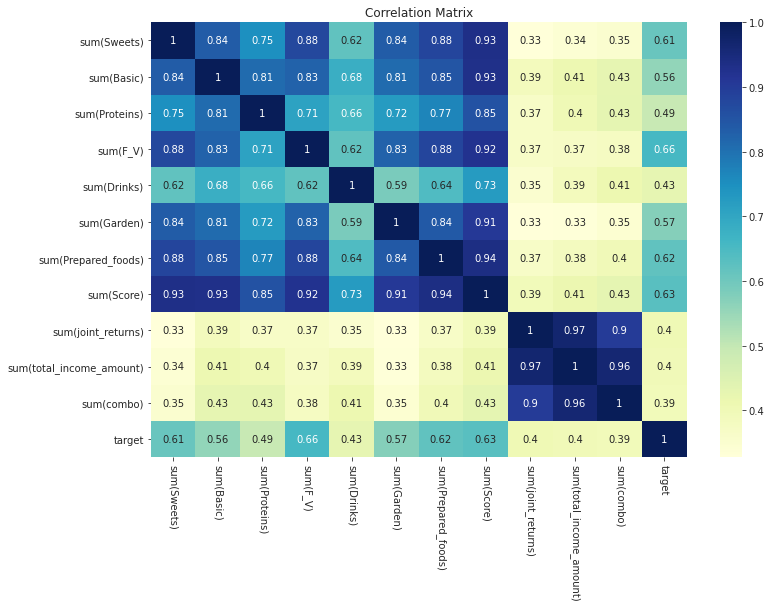

In [ ]:
# Call function
corr_columns = featureCols + target
correlation_matrix(joined, corr_columns)

## Multicollinearity

We need to remove all features that have a strong correlation (>=0.8) among them before modeling.

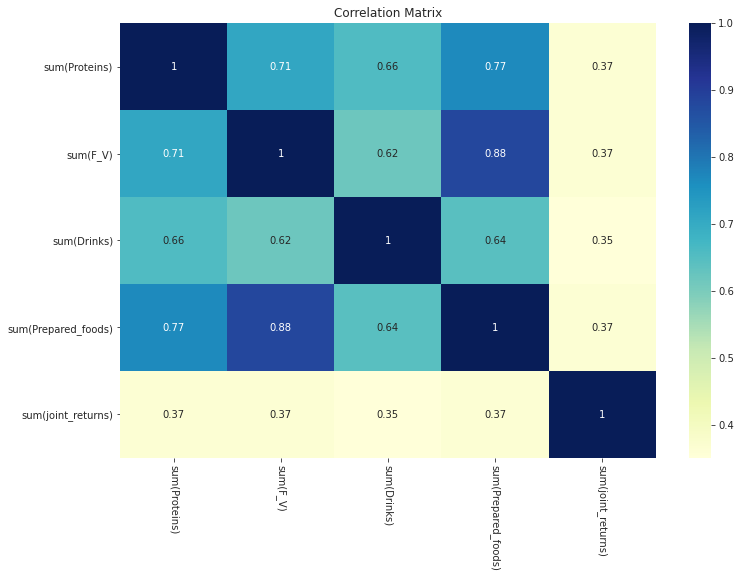

In [ ]:
# Call function
nonFeatureCols = ['target','zip','zipcode','zipcodes','sum(zip)', 'sum(zipcode)','target','sum(Score)','sum(Basic)','sum(Prepared_food)','sum(Garden)','sum(Sweets)','sum(total_income_amount)','sum(combo)']
featureCols2 = [item for item in joined.columns if item not in nonFeatureCols]

corr_columns = featureCols2
correlation_matrix(joined, corr_columns)

# Features prep

### Re-define features

In [ ]:
# Define DF for modeling
df = joined

# Define features/target retained for modeling
print('List of features for modeling:\n', featureCols2)
print('Target variable:', target)

List of features for modeling:
 ['sum(Proteins)', 'sum(F_V)', 'sum(Drinks)', 'sum(Prepared_foods)', 'sum(joint_returns)']
Target variable: ['target']


### VectorAssembler

In [ ]:
# Combine features to a single DenseVector Column named 'features'
assembler = VectorAssembler()\
              .setInputCols(featureCols2)\
              .setOutputCol('features')

df_vector = assembler.transform(df)

type(df_vector) # not transformed yet

Out[124]: pyspark.sql.dataframe.DataFrame

In [ ]:
# Select only target and vectorized features columns
data = df_vector.select('features','target')
print('Total number of rows in the "data" DF:', data.count())

# Display DF
data.display()

Total number of rows in the "data" DF: 3529


features target Map(vectorType -> dense, length -> 5, values -> List(9.0, 9.0, 7.0, 10.0, 22850.0)) 5.0 Map(vectorType -> dense, length -> 5, values -> List(1.0, 2.0, 1.0, 2.0, 12170.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(8.0, 11.0, 3.0, 11.0, 59790.0)) 8.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(6360.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(3.0, 4.0, 2.0, 4.0, 7840.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(5.0, 7.0, 2.0, 7.0, 46450.0)) 5.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 2.0, 0.0, 2.0, 10940.0)) 2.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(2950.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 2.0, 0.0, 1.0, 3940.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(1, 4), values -> List(1.0, 4440.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(3.0, 2.0, 2.0, 2.0, 17690.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(5.0, 4.0, 0.0, 4.0, 28230.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(2.0, 2.0, 0.0, 1.0, 5430.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 0.0, 1.0, 5790.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(740.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(5.0, 6.0, 4.0, 8.0, 27580.0)) 4.0 Map(vectorType -> dense, length -> 5, values -> List(1.0, 1.0, 1.0, 1.0, 3680.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 0.0, 2.0, 3250.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 0.0, 1.0, 2560.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(21060.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 0.0, 2.0, 6370.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(6.0, 4.0, 2.0, 4.0, 2890.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(4.0, 14.0, 1.0, 5.0, 10000.0)) 8.0 Map(vectorType -> dense, length -> 5, values -> List(1.0, 4.0, 1.0, 2.0, 15690.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(3.0, 2.0, 1.0, 2.0, 1350.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(7.0, 10.0, 6.0, 10.0, 24270.0)) 7.0 Map(vectorType -> dense, length -> 5, values -> List(8.0, 11.0, 7.0, 12.0, 8990.0)) 7.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(5340.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(3.0, 2.0, 2.0, 2.0, 9510.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 8.0, 0.0, 5.0, 10270.0)) 5.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 2.0, 0.0, 2.0, 2090.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 2.0, 2.0, 1.0, 18750.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 0.0, 1.0, 1830.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(5.0, 4.0, 2.0, 2.0, 30480.0)) 4.0 Map(vectorType -> dense, length -> 5, values -> List(2.0, 2.0, 0.0, 1.0, 10010.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(1.0, 1.0, 0.0, 1.0, 4130.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 2.0, 0.0, 2.0, 3050.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(3.0, 4.0, 0.0, 4.0, 10890.0)) 3.0 Map(vectorType -> sparse, length -> 5, indices -> List(1, 4), values -> List(1.0, 25420.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(5.0, 3.0, 0.0, 6.0, 48830.0)) 3.0 Map(vectorType -> dense, length -> 5, values -> List(3.0, 6.0, 3.0, 3.0, 16870.0)) 4.0 Map(vectorType -> dense, length -> 5, values -> List(3.0, 2.0, 3.0, 2.0, 40000.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(1.0, 1.0, 1.0, 2.0, 17720.0)) 2.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(22060.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(2.0, 2.0, 1.0, 2.0, 14780.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(2.0, 2

### Scaler

In [ ]:
from pyspark.ml.feature import StandardScaler
# Scaling features
scaler = StandardScaler().setInputCol('features').setOutputCol('features_scaled')

# Normalize features
features_scaled = scaler.fit(data).transform(data)

In [ ]:
# Create DF ready for ML
data_scaled = features_scaled.select('features_scaled','target')
data_scaled.display()

features_scaled target Map(vectorType -> dense, length -> 5, values -> List(3.7033701771718586, 3.567558543022056, 4.621529833895543, 4.60937029231269, 0.025670657078566684)) 5.0 Map(vectorType -> dense, length -> 5, values -> List(0.4114855752413176, 0.7927907873382347, 0.6602185476993633, 0.921874058462538, 0.013672293069853679)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(3.291884601930541, 4.360349330360291, 1.98065564309809, 5.070307321543959, 0.0671706164869804)) 8.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(0.00714509317372797)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(1.234456725723953, 1.5855815746764694, 1.3204370953987266, 1.843748116925076, 0.00880778781163951)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(2.0574278762065883, 2.7747677556838215, 1.3204370953987266, 3.226559204618883, 0.052183895899318274)) 5.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 0.7927907873382347, 0.0, 0.921874058462538, 0.01229045901267044)) 2.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(0.0033141548525939483)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 0.7927907873382347, 0.0, 0.460937029231269, 0.004426362752278019)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(1, 4), values -> List(0.39639539366911736, 0.004988083913734621)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(1.234456725723953, 0.7927907873382347, 1.3204370953987266, 0.921874058462538, 0.01987369469233456)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(2.0574278762065883, 1.5855815746764694, 0.0, 1.843748116925076, 0.03171477677583972)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(0.8229711504826352, 0.7927907873382347, 0.0, 0.460937029231269, 0.006100291813418692)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 0.39639539366911736, 0.0, 0.460937029231269, 0.006504731049667444)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(8.313473189557701E-4)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(2.0574278762065883, 2.378372362014704, 2.640874190797453, 3.687496233850152, 0.030984539265946135)) 4.0 Map(vectorType -> dense, length -> 5, values -> List(0.4114855752413176, 0.39639539366911736, 0.6602185476993633, 0.460937029231269, 0.0041342677483205865)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 0.39639539366911736, 0.0, 0.921874058462538, 0.0036511875494679093)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 0.39639539366911736, 0.0, 0.460937029231269, 0.0028760123466577995)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(0.02365969532055205)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 0.39639539366911736, 0.0, 0.921874058462538, 0.007156327596957102)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(2.468913451447906, 1.5855815746764694, 1.3204370953987266, 1.843748116925076, 0.003246748313219156)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(1.6459423009652705, 5.549535511367643, 0.6602185476993633, 2.304685146156345, 0.011234423229132028)) 8.0 Map(vectorType -> dense, length -> 5, values -> List(0.4114855752413176, 1.5855815746764694, 0.6602185476993633, 0.921874058462538, 0.01762681004650815)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(1.234456725723953, 0.7927907873382347, 0.6602185476993633, 0.921874058462538, 0.001516647135932824)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(2.8803990266892234, 3.9639539366911736, 3.96131128619618, 4.60937029231269, 0.027265945177103432)) 7.0 Map(vectorType -> dense, length -> 5, values -> List(3.291884601930541, 4.360349330360291, 4.621529833895543, 5.5312443507752285, 0.010099746482989693)) 7.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(0.0059991820043565035)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(1.234456725723953, 0.792

# Split

In [ ]:
# Split scaled data
train, test = data_scaled.randomSplit([0.75,0.25], seed=0)

# Cache data
train.cache()
test.cache()

print('Number of rows for train:', train.count())
print('Number of rows for test:', test.count())

Number of rows for train: 2658
Number of rows for test: 871


### Data distribution

In [ ]:
def check_dataset_balance(target):
    
    # find unique values' value counts & percentage
    unique = pd.DataFrame(target.value_counts()).reset_index()
    unique.columns = ['Target', 'value_count']
    total_counts = target.shape[0]
    unique = unique.assign(response_percentage = (unique['value_count']/total_counts*100).round(1))
    print(unique, '\n')

    # plot a bar chart of response percentage to see if data are balanced
    graph = sns.barplot(x = "Target", y = "response_percentage", data = unique)
    for p in graph.patches:
        graph.annotate('{:.1f}%'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom', color= 'black')
    plt.show()

**Entire dataframe**

    Target  value_count  response_percentage
0      1.0         1649                 46.7
1      2.0          954                 27.0
2      3.0          497                 14.1
3      4.0          189                  5.4
4      5.0          102                  2.9
5      6.0           43                  1.2
6      7.0           40                  1.1
7      8.0           15                  0.4
8      9.0           10                  0.3
9     11.0            9                  0.3
10    10.0            6                  0.2
11    13.0            5                  0.1
12    12.0            3                  0.1
13    14.0            3                  0.1
14    15.0            2                  0.1
15    18.0            1                  0.0
16    16.0            1                  0.0 



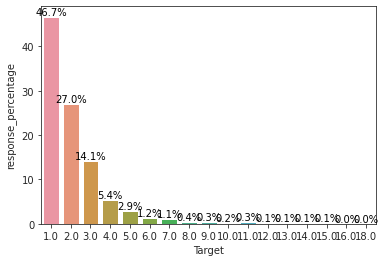

In [ ]:
# Convert df_sql --> df_pd
df_pd = df.toPandas()

# Check initial data distributions
check_dataset_balance(df_pd.target)

**Training set**

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features_scaled. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
>> Target distribution in the training set << 

    Target  value_count  response_percentage
0      1.0         1235                 46.5
1      2.0          735                 27.7
2      3.0          371                 14.0
3      4.0          139                  5.2
4      5.0           72                  2.7
5      6.0           33                  1.2
6      7.0           29                  1.1
7      8.0           11 

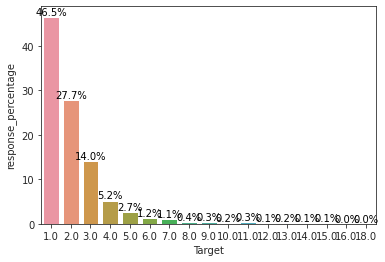

In [ ]:
# Convert df_sql --> df_pd
train_pd = train.toPandas()

# Data distribution - training set  
print('>> Target distribution in the training set << \n')
check_dataset_balance(train_pd.target)

**Test set**

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features_scaled. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
>> Target distribution in the test set << 

    Target  value_count  response_percentage
0      1.0          414                 47.5
1      2.0          219                 25.1
2      3.0          126                 14.5
3      4.0           50                  5.7
4      5.0           30                  3.4
5      7.0           11                  1.3
6      6.0           10                  1.1
7      8.0            4     

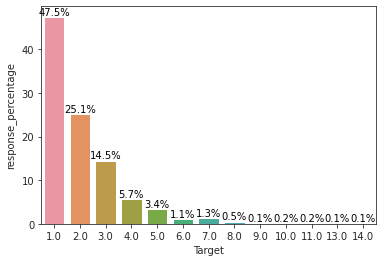

In [ ]:
# Convert df_sql --> df_pd
test_pd = test.toPandas()

# Data distribution - trest set  
print('>> Target distribution in the test set << \n')
check_dataset_balance(test_pd.target)

# Regressor

## Pipeline

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from time import time
import numpy as np
import math

# Define input
start = time()
df = joined
featureCols = featureCols2
label = 'target'
metric = 'rmse'
evaluator = RegressionEvaluator().setMetricName(metric).setLabelCol(label)
# algorithm = RandomForestRegressor()
algorithm = DecisionTreeRegressor()
numFolds = 5

# ----------------- Split ----------------------
train, test = df.randomSplit([0.75,0.25], seed=0)
train.cache()
test.cache()
train_sample = train.sample(fraction=0.1)

# ----------------- Stage 1 ----------------------
assemblerInputs = featureCols
assembler = VectorAssembler()\
            .setInputCols(assemblerInputs)\
            .setOutputCol('features')

# ----------------- Stage 2 ----------------------
scaler = StandardScaler()\
        .setInputCol(assembler.getOutputCol())\
        .setOutputCol('features_scaled')

# ----------------- Stage 3 ----------------------
regressor = algorithm\
            .setFeaturesCol(scaler.getOutputCol())\
            .setLabelCol(label)

# ----------------- Pipeline ----------------------
stages = [assembler, scaler, regressor] 
pipeline = Pipeline().setStages(stages)

# ------------- Hyperparameter (GridSearch) -------------
maxDepth = [5,8,10]
numTrees = [20,40]
paramGrid = ParamGridBuilder()\
                .addGrid(regressor.maxDepth, maxDepth)\
                .addGrid(regressor.numTrees, numTrees)\
                .build()

# -------------CrossValidation --------------
cv = CrossValidator()\
     .setEstimator(pipeline)\
     .setEstimatorParamMaps(paramGrid)\
     .setEvaluator(evaluator)\
     .setNumFolds(numFolds)\
     .setParallelism(2) # number of cores available


#------------- MLflow ----------------------
experiment_name = '/Users/sfortier@mun.ca/Experiment_test'
mlflow.set_experiment(experiment_name)
mlflow.pyspark.ml.autolog(log_models=True)

# ------------- Train model ---------------------
# cvModel = cv.fit(train_sample)
with mlflow.start_run(run_name='dtr_default') as run:
    cvModel = cv.fit(train_sample)
#-----------------------------------------------------
# Processing time
print(f'Elasped time : {np.round((time() - start)/60, 2)} min') # 23 min RF RS / 36 min DT GS 

Elasped time : 36.14 min


**Best Model Hyperparameters**

In [ ]:
print('Best Model:\n------------')
print(cvModel.bestModel.stages[-1], '\n')

print(f'Best Hyperparameters to optimize {metric}:\n---------------------------------------')
param_dict = cvModel.bestModel.stages[-1].extractParamMap()
dictionnary = {}

for key, value in param_dict.items():
  dictionnary[key.name] = value
dictionnary

Best Model:
------------
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_788046c93d80, depth=5, numNodes=39, numFeatures=5 

Best Hyperparameters to optimize rmse:
---------------------------------------
Out[144]: {'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featuresCol': 'features_scaled',
 'impurity': 'variance',
 'labelCol': 'target',
 'leafCol': '',
 'maxBins': 32,
 'maxDepth': 5,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'minWeightFractionPerNode': 0.0,
 'predictionCol': 'prediction',
 'seed': -1407754390808368278}

## Performance metrics

### (i) Predictions

In [ ]:
cvPred_train = (cvModel.bestModel
                   .transform(train)
                   .selectExpr('prediction AS raw_prediction', 
                           'double(round(prediction)) AS rounded_prediction', 
                           'target', 
                           '''CASE double(round(prediction)) = target 
                                  WHEN true THEN 1
                                  ELSE 0
                              END AS sameAsTarget''')
           )
acc_train = cvPred_train.selectExpr('sum(sameAsTarget)/sum(1)').first()[0]*100
print(f'Overall "accuracy" of the Regression Model using training set:\n {np.round(acc_train,1)}%')
# display(cvPred_train.selectExpr('sum(sameAsTarget)/sum(1)'))

Overall "accuracy" of the Regression Model using training set:
 43.7%


In [ ]:
cvPred_test = (cvModel.bestModel
                   .transform(test)
                   .selectExpr('prediction AS raw_prediction', 
                           'double(round(prediction)) AS rounded_prediction', 
                           'target', 
                           '''CASE double(round(prediction)) = target 
                                  WHEN true THEN 1
                                  ELSE 0
                              END AS sameAsTarget''')
           )
acc_test = cvPred_test.selectExpr('sum(sameAsTarget)/sum(1)').first()[0]*100
print(f'Overall "accuracy" of the Regression Model using testing set:\n {np.round(acc_test,1)}%')

Overall "accuracy" of the Regression Model using training set:
 42.9%


### (ii) Using Regression Metrics

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics

rm = RegressionMetrics(cvPred_train.select('rounded_prediction', 'target')\
                                   .rdd.map(lambda x:  (x[0], x[1])))

mse_train = np.round(rm.meanSquaredError, 2)
mae_train = np.round(rm.meanAbsoluteError, 2)
rmse_train = np.round(rm.rootMeanSquaredError, 2)
r2_train = np.round(rm.r2, 2)
var_train = np.round(rm.explainedVariance, 2)

print(f'''
Regression metrics using training set:
MSE:\t\t {mse_train}
MAE:\t\t {mae_train}
RMSE:\t\t {rmse_train}
R Squared:\t {r2_train}
Expl Variance:\t {var_train}
''')

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(

Regression metrics using training set:
MSE:		 1.52
MAE:		 0.73
RMSE:		 1.23
R Squared:	 0.49
Expl Variance:	 2.38



In [ ]:
rm2 = RegressionMetrics(cvPred_test.select('rounded_prediction', 'target')\
                                   .rdd.map(lambda x:  (x[0], x[1])))

mse_test = np.round(rm2.meanSquaredError, 2)
mae_test = np.round(rm2.meanAbsoluteError, 2)
rmse_test = np.round(rm2.rootMeanSquaredError, 2)
r2_test = np.round(rm2.r2, 2)
var_test = np.round(rm2.explainedVariance, 2)

print(f'''
Regression metrics using test set:
MSE:\t\t {mse_test}
MAE:\t\t {mae_test}
RMSE:\t\t {rmse_test}
R Squared:\t {r2_test}
Expl Variance:\t {var_test}
''')


Regression metrics using test set:
MSE:		 1.28
MAE:		 0.71
RMSE:		 1.13
R Squared:	 0.4
Expl Variance:	 1.94



### (iii) Using Regressor Evaluator

In [ ]:
print('Regression metrics using the Evaluator (train):')

metrics = ['mse','mae','rmse','r2','var']

for metric in metrics:
    evaluator = RegressionEvaluator(
                predictionCol='rounded_prediction',
                labelCol=label,
                metricName=metric)

    output = evaluator.evaluate(cvPred_train)
    print(f'{metric} =\t', np.round(output,2))

Regression metrics using the Evaluator (train):
mse =	 1.52
mae =	 0.73
rmse =	 1.23
r2 =	 0.49
var =	 2.38


In [ ]:
print('Regression metrics using the Evaluator (test):')

metrics = ['mse','mae','rmse','r2','var']

for metric in metrics:
    evaluator = RegressionEvaluator(
                predictionCol='rounded_prediction',
                labelCol=label,
                metricName=metric)

    output = evaluator.evaluate(cvPred_test)
    print(f'{metric} =\t', np.round(output,2))

Regression metrics using the Evaluator (test):
mse =	 1.28
mae =	 0.71
rmse =	 1.13
r2 =	 0.4
var =	 1.94


In [ ]:
print(f'''
>>Observations<<

The previous RandomForestRegressor model built had the following performance metrics:
    - MSE \t 7.82
    - MAE \t 1.13
    - RMSE \t 2.80
    - R^2 \t -2.44
    - Var \t 7.04
    - Accuracy \t 38.0%
    
The current RandomForestRegressor built including additional features, and doing a better job during the pre-processing steps for features selection, the model performed much better:
    - MSE \t {mse_test}
    - MAE \t {mae_test}
    - RMSE \t {rmse_test}
    - R^2 \t {r2_test}
    - Var \t {var_test}
    - Accuracy \t {np.round(acc_test,1)}%
    
''')


>>Observations<<

The previous RandomForestRegressor model built had the following performance metrics:
    - MSE 	 7.82
    - MAE 	 1.13
    - RMSE 	 2.80
    - R^2 	 -2.44
    - Var 	 7.04
    - Accuracy 	 38.0%
    
The current RandomForestRegressor built including additional features, and doing a better job during the pre-processing steps for features selection, the model performed much better:
    - MSE 	 1.28
    - MAE 	 0.71
    - RMSE 	 1.13
    - R^2 	 0.4
    - Var 	 1.94
    - Accuracy 	 42.9%
    



# Using the Apache Spark ML pipeline, build a model to predict the price of a diamond based on the available features.




Read from the following notebook for details about dataset.

https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/5915990090493625/4396972618536508/6085673883631125/latest.html

(https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/5915990090493625/4396972618536508/6085673883631125/latest.html)



# 1) Data Integration

In [ ]:
# Read DS
file_path = "/databricks-datasets/Rdatasets/data-001/csv/ggplot2/diamonds.csv"

diamonds_df = (spark.read 
                 .format('csv') 
                 .option('header', True) 
                 .option('inferSchema', True)
                 .option('nullValue','NULL')
                 .load(file_path))

In [ ]:
# Convert DF --> table
diamonds_df.createOrReplaceTempView('diamonds_table')

In [ ]:
# Clone DF
df_orig = diamonds_df
df_orig.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- price: integer (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



# 2) Data Cleaning

## Head

In [ ]:
# Display first rows
diamonds_df.limit(5).display()

_c0 carat cut color clarity depth table price x y z 1 0.23 Ideal E SI2 61.5 55.0 326 3.95 3.98 2.43 2 0.21 Premium E SI1 59.8 61.0 326 3.89 3.84 2.31 3 0.23 Good E VS1 56.9 65.0 327 4.05 4.07 2.31 4 0.29 Premium I VS2 62.4 58.0 334 4.2 4.23 2.63 5 0.31 Good J SI2 63.3 58.0 335 4.34 4.35 2.75

In [ ]:
# Drop first column
diamonds_df = diamonds_df.drop('_c0')

## Shape

In [ ]:
# get the dimensions of the dataset
print(f'There are {diamonds_df.count()} rows and {len(diamonds_df.columns)} columns in the dataset')

There are 53940 rows and 10 columns in the dataset


## Column names

In [ ]:
diamonds_df.columns

Out[9]: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']

## Dtypes

In [ ]:
diamonds_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- price: integer (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



Observation: <br>
All dtypes are good except for the price which should be a float (double is not needed here) for the regression predictive model. <br>

In [ ]:
# Convert integer --> float
diamonds_df = diamonds_df.withColumn('price', diamonds_df.price.cast('float'))
diamonds_df.printSchema()

root
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- price: float (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



Since double is not needed and may slowdown some operations, we should change them all for floats.

In [ ]:
# Convert integer --> float
cols_to_cast = ['carat','x','y','z','depth','table']

diamonds_df = diamonds_df.select(*(c for c in diamonds_df.columns if c not in cols_to_cast),
                                 *(col(c).cast('float').alias(c) for c in cols_to_cast) )
diamonds_df.printSchema()

root
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- price: float (nullable = true)
 |-- carat: float (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- z: float (nullable = true)
 |-- depth: float (nullable = true)
 |-- table: float (nullable = true)



## Duplicates

In [ ]:
if diamonds_df.count() > diamonds_df.dropDuplicates(diamonds_df.columns).count():
    raise ValueError('Dataset has duplicates')
else:
    print('No duplicates, you are Good to go!')

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<command-743093780475225> in <module>
      1 if diamonds_df.count() > diamonds_df.dropDuplicates(diamonds_df.columns).count():
----> 2     raise ValueError('Dataset has duplicates')
      3 else:
      4     print('No duplicates, you are Good to go!')

ValueError: Dataset has duplicates

There are not duplicates

In [ ]:
# Display duplicates
duplicate = diamonds_df.dropDuplicates()
print(f'There is {duplicate.count()} duplicate(s) in the dataset')

diamonds_df.exceptAll(diamonds_df.dropDuplicates(diamonds_df.columns)).toPandas() 

## Missing values

In [ ]:
# Find NaN
for col in diamonds_df.columns:
    print(col +'\t', diamonds_df.count() - (diamonds_df.na.drop(subset=col).count()))

carat	 0
cut	 0
color	 0
clarity	 0
depth	 0
table	 0
price	 0
x	 0
y	 0
z	 0


## Unique values

In [ ]:
%sql
SELECT DISTINCT cut
FROM diamonds_table

cut Premium Ideal Good Fair Very Good

In [ ]:
# Display unique values for strings
strings = ['cut','color','clarity']

for s in strings:
    print(diamonds_df.select(s).distinct().rdd.flatMap(lambda x: x).collect())

['Premium', 'Ideal', 'Good', 'Fair', 'Very Good']
['F', 'E', 'D', 'J', 'G', 'I', 'H']
['VVS2', 'SI1', 'IF', 'I1', 'VVS1', 'VS2', 'SI2', 'VS1']


# 3) EDA

## Define features - 1

In [ ]:
target = ['price']

features = [col for col in diamonds_df.columns if col != 'price']

cat_features = ['cut','color','clarity']

num_features = [col for col in diamonds_df.columns if col not in (target + cat_features)]

print(f"""

All features:
{features}

Categorial features:
{cat_features}

Numerical features:
{num_features}

""")



All features:
['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']

Categorial features:
['cut', 'color', 'clarity']

Numerical features:
['carat', 'depth', 'table', 'x', 'y', 'z']




## Data distribution

**Numerical**

/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

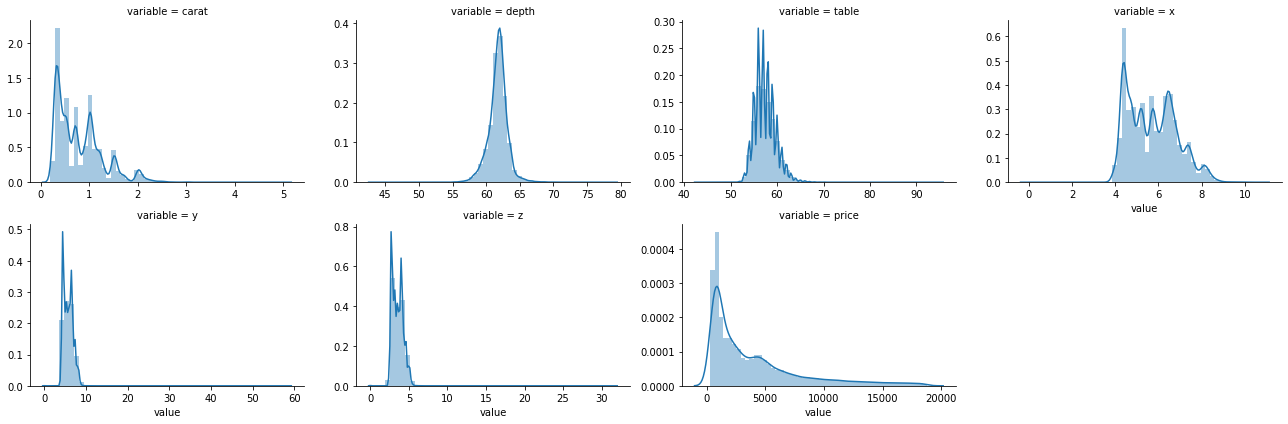

In [ ]:
# Convert df_sql to df_pd
diamonds_df_pd = diamonds_df.toPandas()

# data wide to long
num_cols = diamonds_df_pd[num_features + target].melt()

# plot the distribution of all num columns (features & target)
plt.figure(figsize=(10,8))
g = sns.FacetGrid(data=num_cols, col='variable', col_wrap=4, sharex=False, sharey=False, aspect=1.5)
g.map(sns.distplot, 'value');

Observation: <br>
The vast majority of diamonds are less than $3000 meaning that it will be more difficult for the model to learn and predict more expensive diamonds but should perform fairly well at predicting less expensive diamonds.

**Categorical**

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


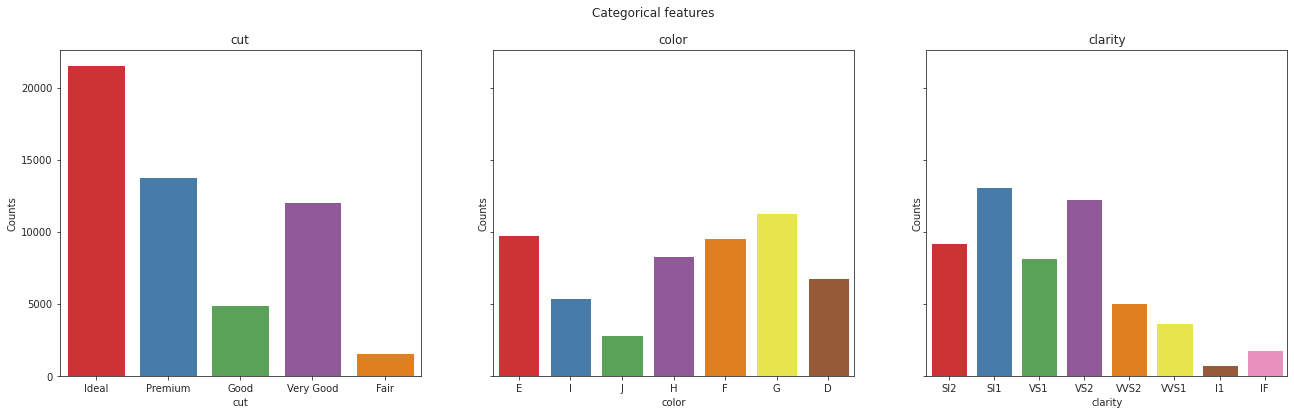

In [ ]:
# Count value for categorical features
sns.set_style('ticks')
fig, axes = plt.subplots(1,3, figsize=(22,6), sharey=True)
  
for ax,var in zip(axes, cat_features): 
    sns.countplot(diamonds_df_pd[var], ax=ax, palette='Set1')
    ax.set_title(var)
    ax.set_ylabel('Counts')
    
plt.suptitle('Categorical features');

## Basic stats

In [ ]:
diamonds_df.describe(num_features + target).toPandas().transpose()

0 
 1 
 2 
 3 
 4 
 
 
 
 
 summary 
 count 
 mean 
 stddev 
 min 
 max 
 
 
 carat 
 53940 
 0.7979397478679852 
 0.4740112444054196 
 0.2 
 5.01 
 
 
 depth 
 53940 
 61.74940489432624 
 1.4326213188336525 
 43.0 
 79.0 
 
 
 table 
 53940 
 57.45718390804603 
 2.2344905628213247 
 43.0 
 95.0 
 
 
 x 
 53940 
 5.731157211716609 
 1.1217607467924915 
 0.0 
 10.74 
 
 
 y 
 53940 
 5.734525954764462 
 1.1421346741235616 
 0.0 
 58.9 
 
 
 z 
 53940 
 3.5387337782723316 
 0.7056988469499883 
 0.0 
 31.8 
 
 
 price 
 53940 
 3932.799721913237 
 3989.439738146397 
 326 
 18823

Observation: <br>
The dimensions (length, width, depth) of diamonds cannot be equal to 0. These are inaccurate values and should be removed from the dataset.<br>

In [ ]:
# Locate values = 0
diamonds_df.filter((diamonds_df.x == 0) | (diamonds_df.y == 0) | (diamonds_df.z == 0)).display()

carat cut color clarity depth table price x y z 1.0 Premium G SI2 59.1 59.0 3142 6.55 6.48 0.0 1.01 Premium H I1 58.1 59.0 3167 6.66 6.6 0.0 1.1 Premium G SI2 63.0 59.0 3696 6.5 6.47 0.0 1.01 Premium F SI2 59.2 58.0 3837 6.5 6.47 0.0 1.5 Good G I1 64.0 61.0 4731 7.15 7.04 0.0 1.07 Ideal F SI2 61.6 56.0 4954 0.0 6.62 0.0 1.0 Very Good H VS2 63.3 53.0 5139 0.0 0.0 0.0 1.15 Ideal G VS2 59.2 56.0 5564 6.88 6.83 0.0 1.14 Fair G VS1 57.5 67.0 6381 0.0 0.0 0.0 2.18 Premium H SI2 59.4 61.0 12631 8.49 8.45 0.0 1.56 Ideal G VS2 62.2 54.0 12800 0.0 0.0 0.0 2.25 Premium I SI1 61.3 58.0 15397 8.52 8.42 0.0 1.2 Premium D VVS1 62.1 59.0 15686 0.0 0.0 0.0 2.2 Premium H SI1 61.2 59.0 17265 8.42 8.37 0.0 2.25 Premium H SI2 62.8 59.0 18034 0.0 0.0 0.0 2.02 Premium H VS2 62.7 53.0 18207 8.02 7.95 0.0 2.8 Good G SI2 63.8 58.0 18788 8.9 8.85 0.0 0.71 Good F SI2 64.1 60.0 2130 0.0 0.0 0.0 0.71 Good F SI2 64.1 60.0 2130 0.0 0.0 0.0 1.12 Premium G I1 60.4 59.0 2383 6.71 6.67 0.0

In [ ]:
# Remove rows equal to 0
diamonds_df2 = diamonds_df.where((diamonds_df.x != 0) & (diamonds_df.y != 0) & (diamonds_df.z != 0))

In [ ]:
diamonds_df2.describe(num_features + target).toPandas().transpose()

0 
 1 
 2 
 3 
 4 
 
 
 
 
 summary 
 count 
 mean 
 stddev 
 min 
 max 
 
 
 carat 
 53920 
 0.7976982566765384 
 0.47379529239063944 
 0.2 
 5.01 
 
 
 depth 
 53920 
 61.7495140949547 
 1.4323310748193272 
 43.0 
 79.0 
 
 
 table 
 53920 
 57.456834198813105 
 2.2340642090636664 
 43.0 
 95.0 
 
 
 x 
 53920 
 5.731626854599296 
 1.119422825791889 
 3.73 
 10.74 
 
 
 y 
 53920 
 5.734887054896052 
 1.1401257950841792 
 3.68 
 58.9 
 
 
 z 
 53920 
 3.5400463649853404 
 0.7025303439301769 
 1.07 
 31.8 
 
 
 price 
 53920 
 3930.993230712166 
 3987.280445975295 
 326 
 18823

## Shape

In [ ]:
# get the dimensions of the dataset
print(f'There are {diamonds_df2.count()} rows and {len(diamonds_df2.columns)} columns in the dataset')

There are 53920 rows and 10 columns in the dataset


# 4) Feature Selection

## Correlations

**Bivariate**

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

# Define function
def correlation_matrix(df, corr_columns, method='spearman'):

    #Combine features for correlation to a single DenseVector
    vector_col = 'corr_features'
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    
    # Compute correlation
    matrix = Correlation.corr(df_vector, vector_col, method)

    # Change matrix format
    result = matrix.collect()[0]['spearman({})'.format(vector_col)].values
    matrix_np = result.reshape(len(corr_columns),len(corr_columns))

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.heatmap(matrix_np, annot=True, cmap='YlGnBu')
    ax.xaxis.set_ticklabels(corr_columns, rotation=270)
    ax.yaxis.set_ticklabels(corr_columns, rotation=0)
    ax.set_title('Correlation Matrix');
    
    # Return DF
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


carat 
 depth 
 table 
 x 
 y 
 z 
 price 
 
 
 
 
 carat 
 1.000000 
 0.030146 
 0.194941 
 0.996645 
 0.996033 
 0.994708 
 0.962888 
 
 
 depth 
 0.030146 
 1.000000 
 -0.245098 
 -0.023214 
 -0.025186 
 0.103568 
 0.010013 
 
 
 table 
 0.194941 
 -0.245098 
 1.000000 
 0.202294 
 0.195833 
 0.160294 
 0.171797 
 
 
 x 
 0.996645 
 -0.023214 
 0.202294 
 1.000000 
 0.997961 
 0.988378 
 0.963754 
 
 
 y 
 0.996033 
 -0.025186 
 0.195833 
 0.997961 
 1.000000 
 0.988141 
 0.963215 
 
 
 z 
 0.994708 
 0.103568 
 0.160294 
 0.988378 
 0.988141 
 1.000000 
 0.958593 
 
 
 price 
 0.962888 
 0.010013 
 0.171797 
 0.963754 
 0.963215 
 0.958593 
 1.000000

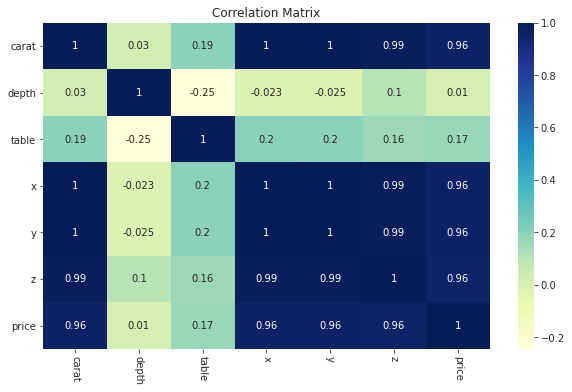

In [ ]:
# Call function
corr_columns = num_features + target
correlation_matrix(diamonds_df2, corr_columns)

Observation: <br>
Depth is not at all related to price but carat and all dimensions are related strongly.

## Multicollinearity

We need to remove potential risk of multicollinearity (>0.8) among features.

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


carat 
 depth 
 table 
 x 
 y 
 z 
 
 
 
 
 carat 
 1.000000 
 0.030146 
 0.194941 
 0.996645 
 0.996033 
 0.994708 
 
 
 depth 
 0.030146 
 1.000000 
 -0.245098 
 -0.023214 
 -0.025186 
 0.103568 
 
 
 table 
 0.194941 
 -0.245098 
 1.000000 
 0.202294 
 0.195833 
 0.160294 
 
 
 x 
 0.996645 
 -0.023214 
 0.202294 
 1.000000 
 0.997961 
 0.988378 
 
 
 y 
 0.996033 
 -0.025186 
 0.195833 
 0.997961 
 1.000000 
 0.988141 
 
 
 z 
 0.994708 
 0.103568 
 0.160294 
 0.988378 
 0.988141 
 1.000000

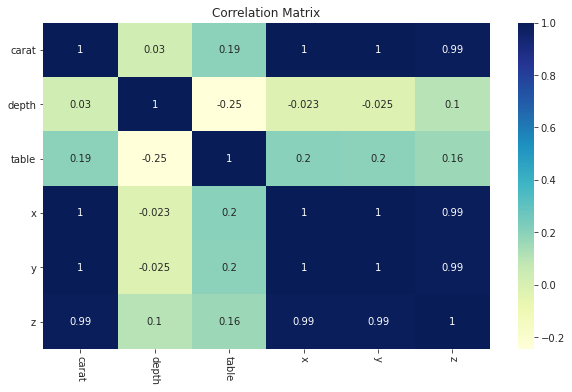

In [ ]:
# Call function
corr_columns = num_features
correlation_matrix(diamonds_df2, corr_columns)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


carat 
 depth 
 table 
 
 
 
 
 carat 
 1.000000 
 0.030146 
 0.194941 
 
 
 depth 
 0.030146 
 1.000000 
 -0.245098 
 
 
 table 
 0.194941 
 -0.245098 
 1.000000

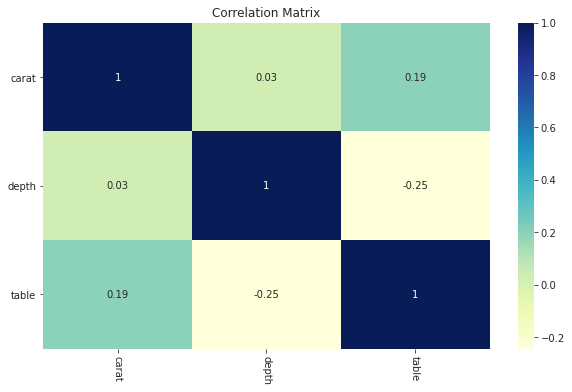

In [ ]:
# Call function
Remove = ['x','y','z']
num_features2 = [var for var in num_features if var not in Remove]

corr_columns = num_features2
correlation_matrix(diamonds_df2, corr_columns)

## Define features - 2

In [ ]:
# Define DF
df = diamonds_df2

# Define target
target = ['price']

# Define features
cat_features = ['cut','color','clarity']

num_features = num_features2

features = cat_features + num_features

print(f"""

Target variable:
{target}

All features:
{features}

Categorial features:
{cat_features}

Numerical features:
{num_features}

""")



Target variable:
['price']

All features:
['cut', 'color', 'clarity', 'carat', 'depth', 'table']

Categorial features:
['cut', 'color', 'clarity']

Numerical features:
['carat', 'depth', 'table']




## Encoder
We cannot use the StringIndexer and the OneHotEncoder because the order matters (nominal features). So, we will do it manually to ensure that they are properly indexed in order of importance.

In [ ]:
# cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
df2 = df.withColumn('cutIndex', when(df.cut == 'Fair', 1)
                                .when(df.cut == 'Good', 2)
                                .when(df.cut == 'Very Good', 3)
                                .when(df.cut == 'Premium', 4)
                                .otherwise(5) )

# color: diamond colour, from D (best) to J (worst)
df2 = df2.withColumn('colorIndex', when(df2.color == 'D', 7)
                                  .when(df2.color == 'E', 6)
                                  .when(df2.color == 'F', 5)
                                  .when(df2.color == 'G', 4)
                                  .when(df2.color == 'H', 3)
                                  .when(df2.color == 'I', 2)
                                  .otherwise(1) )

# # clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
df2 = df2.withColumn('clarityIndex', when(df2.clarity == 'I1', 1)
                                    .when(df2.clarity == 'SI2', 2)
                                    .when(df2.clarity == 'SI1', 3)
                                    .when(df2.clarity == 'VS2', 4)
                                    .when(df2.clarity == 'VS1', 5)
                                    .when(df2.clarity == 'VVS2', 6)
                                    .when(df2.clarity == 'VVS1', 7)
                                    .otherwise(8) )

## Define features - 3

In [ ]:
# Define DF
df = df2

# Define target
target = 'price'

# Define features
cat_features = ['cutIndex','colorIndex','clarityIndex']

num_features = num_features

featureCols = cat_features + num_features

print(f"""

Target variable:
{target}

All features:
{featureCols}

Categorial features:
{cat_features}

Numerical features:
{num_features}

""")



Target variable:
price

All features:
['cutIndex', 'colorIndex', 'clarityIndex', 'carat', 'depth', 'table']

Categorial features:
['cutIndex', 'colorIndex', 'clarityIndex']

Numerical features:
['carat', 'depth', 'table']




## Assembler

In [ ]:
# Combine features to a single DenseVector Column named 'features'
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler()\
              .setInputCols(featureCols)\
              .setOutputCol('features')

df_vector = assembler.transform(df)

## Scaler

In [ ]:
# Scaling features
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler().setInputCol(assembler.getOutputCol()).setOutputCol('features_scaled')

# Normalize features
features_scaled = scaler.fit(df_vector).transform(df_vector)

# Select only features and target for ML
data_scaled = features_scaled.select('features_scaled', target)
data_scaled

2022/03/10 12:13:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b26b0e18b816487391550a72d2f3451f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
Out[30]: DataFrame[features_scaled: vector, price: int]

# 5) Modeling

## A) Pipeline - Baseline
**Linear Regression Model**

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from time import time
import numpy as np
start = time()

################## Step 0: Import #######################################################
file_path = "/databricks-datasets/Rdatasets/data-001/csv/ggplot2/diamonds.csv"
df = spark.read.format('csv') \
               .option('header', True) \
               .option('inferSchema', True) \
               .option('nullValue','NULL') \
               .load(file_path)

################## Step 1: Start MLflow ############################################### 
with mlflow.start_run(run_name='untuned_linReg_model') as run:
    
################## Step 2: Define Inputs ################################################# 
    algorithm = LinearRegression()           
    label = 'price'

################## Step 3: Basic Cleaning ################################################## 
    # A) Drop unnecessary columns
    df = df.drop('_c0','x','y','z') 

    # B) Convert num_features to float
    cols_to_cast = ['carat','depth','table','price']
    df = df.select(*(c for c in df.columns if c not in cols_to_cast),
                   *(col(c).cast('float') for c in cols_to_cast) )              
             
################## Step 4: Pre-Precessing #################################################### 
# ---------------- Stage A: Encoder ----------------
    df = df.withColumn('cutIndex', 
                        when(df.cut == 'Fair', 1)
                       .when(df.cut == 'Good', 2)
                       .when(df.cut == 'Very Good', 3)
                       .when(df.cut == 'Premium', 4)
                       .otherwise(5))
    df = df.withColumn('colorIndex', 
                        when(df.color == 'D', 7)
                       .when(df.color == 'E', 6)
                       .when(df.color == 'F', 5)
                       .when(df.color == 'G', 4)
                       .when(df.color == 'H', 3)
                       .when(df.color == 'I', 2)
                       .otherwise(1))
    df = df.withColumn('clarityIndex', 
                        when(df.clarity == 'I1', 1)
                       .when(df.clarity == 'SI2', 2)
                       .when(df.clarity == 'SI1', 3)
                       .when(df.clarity == 'VS2', 4)
                       .when(df.clarity == 'VS1', 5)
                       .when(df.clarity == 'VVS2', 6)
                       .when(df.clarity == 'VVS1', 7)
                       .otherwise(8))

# ---------------- Stage B: Assembler ----------------
    featureCols = [col for col in df.columns if (col != 'price') & (col != 'cut') & (col != 'color') & (col != 'clarity')]   
    assembler = VectorAssembler()\
                .setInputCols(featureCols)\
                .setOutputCol('features')

# ---------------- Stage C: Scaler ----------------
    scaler = MinMaxScaler()\
            .setInputCol(assembler.getOutputCol())\
            .setOutputCol('features_scaled')

# ---------------- Stage D: Regressor ----------------
    regressor = algorithm\
                .setFeaturesCol(scaler.getOutputCol())\
                .setLabelCol(label)

################## Step 5: Train/test Split #########################################           
    train, test = df.randomSplit([0.75,0.25], seed=0)
    train.cache()
    test.cache()

################## Step 6: Assemble Pipeline ############################################# 
    stages = [assembler, scaler, regressor] 
    pipeline = Pipeline().setStages(stages)

################## Step 7: Train Model ###############################################
    model_lr = pipeline.fit(train)

#-----------------------------------------------------
print('Number of rows in training set:', train.count())
print('Number of rows in test set:', test.count())
print('='*45)
print(f'run_id: {run.info.run_id}')
print(f'exp_id: {run.info.experiment_id}')
print('='*45) 
print(f'Elasped time : {np.round((time() - start)/60, 2)} min') # 2 min

2022/03/25 10:55:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during pyspark.ml autologging: An error occurred while calling o10932.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:110)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:165)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:125)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:419)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1088)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1061)
	at scala.runtime.java8.JFunct

## B) Pipeline - DTR

### GridSearch

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from time import time
import numpy as np
import math
start = time()

################## Step 0: Import ###############################################
file_path = "/databricks-datasets/Rdatasets/data-001/csv/ggplot2/diamonds.csv"
df = spark.read.format('csv') \
               .option('header', True) \
               .option('inferSchema', True) \
               .option('nullValue','NULL') \
               .load(file_path)

################## Step 1: Start MLflow ############################################### 
with mlflow.start_run(run_name='gridsearch', nested=True) as run:
    
################## Step 2: Define Inputs ################## 
    algorithm = DecisionTreeRegressor()       
    label = 'price'
    metric = 'rmse'
    evaluator = RegressionEvaluator().setMetricName(metric).setLabelCol(label)
    numFolds = 5 # for cv
    core = 2 # max cores available for cv

################## Step 3: Basic Cleaning ################## 
    # A) Drop unnecessary columns
    df = df.drop('_c0','x','y','z') 

    # B) Convert num_features to float
    cols_to_cast = ['carat','depth','table','price']
    df = df.select(*(c for c in df.columns if c not in cols_to_cast),
                   *(col(c).cast('float').alias(c) for c in cols_to_cast) )              
             
################## Step 4: Pre-Precessing ################## 
# ---------------- Stage A: Encoder ----------------
    df = df.withColumn('cutIndex', 
                        when(df.cut == 'Fair', 1)
                       .when(df.cut == 'Good', 2)
                       .when(df.cut == 'Very Good', 3)
                       .when(df.cut == 'Premium', 4)
                       .otherwise(5))
    df = df.withColumn('colorIndex', 
                        when(df.color == 'D', 7)
                       .when(df.color == 'E', 6)
                       .when(df.color == 'F', 5)
                       .when(df.color == 'G', 4)
                       .when(df.color == 'H', 3)
                       .when(df.color == 'I', 2)
                       .otherwise(1))
    df = df.withColumn('clarityIndex', 
                        when(df.clarity == 'I1', 1)
                       .when(df.clarity == 'SI2', 2)
                       .when(df.clarity == 'SI1', 3)
                       .when(df.clarity == 'VS2', 4)
                       .when(df.clarity == 'VS1', 5)
                       .when(df.clarity == 'VVS2', 6)
                       .when(df.clarity == 'VVS1', 7)
                       .otherwise(8))

# ---------------- Stage B: Assembler ----------------
    featureCols = [col for col in df.columns if (col != 'price') & (col != 'cut') \
                   & (col != 'color') & (col != 'clarity')]   
    assembler = VectorAssembler()\
                .setInputCols(featureCols)\
                .setOutputCol('features')

# ---------------- Stage C: Scaler ----------------
    scaler = MinMaxScaler()\
            .setInputCol(assembler.getOutputCol())\
            .setOutputCol('features_scaled')

# ---------------- Stage D: Regressor ----------------
    regressor = algorithm\
                .setFeaturesCol(scaler.getOutputCol())\
                .setLabelCol(label)

################## Step 5: Train/test Split ##################               
    train, test = df.randomSplit([0.75,0.25], seed=0)
    train.cache()
    test.cache()

################## Step 6: Assemble Pipeline ################## 
    stages = [assembler, scaler, regressor] 
    pipeline = Pipeline().setStages(stages)

################## Step 7: HPO: GridSearch ################## 
    maxDepth = [5,10,15]
    maxBins = [20,30,40]
    paramGrid = ParamGridBuilder()\
                .addGrid(regressor.maxDepth, maxDepth)\
                .addGrid(regressor.maxBins, maxBins)\
                .build()
    
################## Step 8: Cross-Validation ################## 
    cv = CrossValidator()\
         .setEstimator(pipeline)\
         .setEstimatorParamMaps(paramGrid)\
         .setEvaluator(evaluator)\
         .setNumFolds(numFolds)\
         .setParallelism(core)

################## Step 9: Train Model ##################  
    cvModel = cv.fit(train)
    
#-----------------------------------------------------
print('Number of rows in training set:', train.count())
print('Number of rows in test set:', test.count())
print('='*45)
print(f'run_id: {run.info.run_id}')
print(f'exp_id: {run.info.experiment_id}')
print('='*45) 
print(f'Elasped time : {np.round((time() - start)/60, 2)} min') # 5 min

2022/03/25 11:00:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during pyspark.ml autologging: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.saveAsTextFileImpl.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:110)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:165)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:125)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:419)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1088)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunct

#### Best Hyperparameters - GridSearch

In [ ]:
print('Best Model:\n------------')
print(cvModel.bestModel.stages[-1], '\n')

print(f'Best Hyperparameters to optimize {metric}:\n---------------------------------------')
param_dict = cvModel.bestModel.stages[-1].extractParamMap()
dictionnary = {}

for key, value in param_dict.items():
    dictionnary[key.name] = value
dictionnary

Best Model:
------------
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_f5df9d93f48e, depth=10, numNodes=1939, numFeatures=6 

Best Hyperparameters to optimize rmse:
---------------------------------------
Out[10]: {'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featuresCol': 'features_scaled',
 'impurity': 'variance',
 'labelCol': 'price',
 'leafCol': '',
 'maxBins': 40,
 'maxDepth': 10,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'minWeightFractionPerNode': 0.0,
 'predictionCol': 'prediction',
 'seed': -1407754390808368278}

### RandomSearch

In [ ]:
class RandomGridBuilder: 
  '''
  Grid builder for random search. Sets up grids for use in CrossValidator in Spark using values randomly sampled from user-provided distributions.
  Distributions should be provided as lambda functions, so that the numbers are generated at call time.
  
  Parameters:
    num_models: Integer (Python) - number of models to generate hyperparameters for
    seed: Integer (Python) - seed (optional, default is None)
    
  Returns:
    param_map: list of parameter maps to use in cross validation.
               
    Returns similar output as Spark ML class ParamGridBuilder and can be used in its place. The above paramGrid provides random hyperparameters for 2 models.
    '''
  
  def __init__(self, num_models, seed=None):
    self._param_grid = {}
    self.num_models = num_models
    self.seed = seed
    
  def addDistr(self, param, distr_generator):
    '''Add distribution based on dictionary generated by function passed to addDistr.'''
    
    if 'pyspark.ml.param.Param' in str(type(param)):
      self._param_grid[param] = distr_generator
    else:
      raise TypeError('param must be an instance of Param')
    return self
  
  def build(self):    
    param_map = []
    for n in range(self.num_models):
      if self.seed:
        # Set seeds for both numpy and random in case either is used for the random distribution
        np.random.seed(self.seed + n)
        random.seed(self.seed + n)
      param_dict = {}
      for param, distr in self._param_grid.items():
        param_dict[param] = distr()
      param_map.append(param_dict)
    return param_map


In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from time import time
import numpy as np
import math
start = time()

################## Step 0: Import ###############################################
file_path = "/databricks-datasets/Rdatasets/data-001/csv/ggplot2/diamonds.csv"
df = spark.read.format('csv') \
               .option('header', True) \
               .option('inferSchema', True) \
               .option('nullValue','NULL') \
               .load(file_path)

################## Step 1: Start MLflow ############################################### 
with mlflow.start_run(run_name='randomsearch', nested=True) as run:
    
################## Step 2: Define Inputs ################## 
    algorithm = DecisionTreeRegressor()       
    label = 'price'
    metric = 'rmse'
    evaluator = RegressionEvaluator().setMetricName(metric).setLabelCol(label)
    numFolds = 5 # for cv
    core = 2 # max cores available for cv

################## Step 3: Basic Cleaning ################## 
    # A) Drop unnecessary columns
    df = df.drop('_c0','x','y','z') 

    # B) Convert num_features to float
    cols_to_cast = ['carat','depth','table','price']
    df = df.select(*(c for c in df.columns if c not in cols_to_cast),
                   *(col(c).cast('float').alias(c) for c in cols_to_cast) )              
             
################## Step 4: Pre-Precessing ################## 
# ---------------- Stage A: Encoder ----------------
    df = df.withColumn('cutIndex', 
                        when(df.cut == 'Fair', 1)
                       .when(df.cut == 'Good', 2)
                       .when(df.cut == 'Very Good', 3)
                       .when(df.cut == 'Premium', 4)
                       .otherwise(5))
    df = df.withColumn('colorIndex', 
                        when(df.color == 'D', 7)
                       .when(df.color == 'E', 6)
                       .when(df.color == 'F', 5)
                       .when(df.color == 'G', 4)
                       .when(df.color == 'H', 3)
                       .when(df.color == 'I', 2)
                       .otherwise(1))
    df = df.withColumn('clarityIndex', 
                        when(df.clarity == 'I1', 1)
                       .when(df.clarity == 'SI2', 2)
                       .when(df.clarity == 'SI1', 3)
                       .when(df.clarity == 'VS2', 4)
                       .when(df.clarity == 'VS1', 5)
                       .when(df.clarity == 'VVS2', 6)
                       .when(df.clarity == 'VVS1', 7)
                       .otherwise(8))

# ---------------- Stage B: Assembler ----------------
    featureCols = [col for col in df.columns if (col != 'price') & (col != 'cut') \
                   & (col != 'color') & (col != 'clarity')]   
    assembler = VectorAssembler()\
                .setInputCols(featureCols)\
                .setOutputCol('features')

# ---------------- Stage C: Scaler ----------------
    scaler = MinMaxScaler()\
            .setInputCol(assembler.getOutputCol())\
            .setOutputCol('features_scaled')

# ---------------- Stage D: Regressor ----------------
    regressor = algorithm\
                .setFeaturesCol(scaler.getOutputCol())\
                .setLabelCol(label)

################## Step 5: Train/test Split ##################               
    train, test = df.randomSplit([0.75,0.25], seed=0)
    train.cache()
    test.cache()

################## Step 6: Assemble Pipeline ################## 
    stages = [assembler, scaler, regressor] 
    pipeline = Pipeline().setStages(stages)

################## Step 7: HPO: RandomSearch ################## 
    paramRandom = RandomGridBuilder(10)\
                .addDistr(regressor.maxDepth, lambda: np.random.randint(5, 15))\
                .addDistr(regressor.maxBins, lambda: np.random.randint(20, 40))\
                .build()
    
################## Step 8: Cross-Validation ################## 
    cv = CrossValidator()\
         .setEstimator(pipeline)\
         .setEstimatorParamMaps(paramRandom)\
         .setEvaluator(evaluator)\
         .setNumFolds(numFolds)\
         .setParallelism(core)

################## Step 9: Train Model ##################  
    cvModel_rdm = cv.fit(train)
    
#-----------------------------------------------------
print('Number of rows in training set:', train.count())
print('Number of rows in test set:', test.count())
print('='*45)
print(f'run_id: {run.info.run_id}')
print(f'exp_id: {run.info.experiment_id}')
print('='*45) 
print(f'Elasped time : {np.round((time() - start)/60, 2)} min') # 5 min

2022/03/25 11:03:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during pyspark.ml autologging: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.saveAsTextFileImpl.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:110)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:165)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:125)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:419)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1088)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunct

#### Best Hyperparameters - RandomSearch

In [ ]:
print('Best Model:\n------------')
print(cvModel_rdm.bestModel.stages[-1], '\n')

print(f'Best Hyperparameters to optimize {metric}:\n---------------------------------------')
param_dict = cvModel_rdm.bestModel.stages[-1].extractParamMap()
dictionnary = {}

for key, value in param_dict.items():
    dictionnary[key.name] = value
dictionnary


Best Model:
------------
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_60d9e1749e44, depth=9, numNodes=1007, numFeatures=6 

Best Hyperparameters to optimize rmse:
---------------------------------------
Out[11]: {'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featuresCol': 'features_scaled',
 'impurity': 'variance',
 'labelCol': 'price',
 'leafCol': '',
 'maxBins': 25,
 'maxDepth': 9,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'minWeightFractionPerNode': 0.0,
 'predictionCol': 'prediction',
 'seed': -1407754390808368278}

### BayesSearch - Hyperopt
https://docs.databricks.com/_static/notebooks/hyperopt-spark-ml.html

**Note** <br>
Since SparkTrials fits and evaluates each model on one Spark worker, it is limited to tuning single-machine ML models and workflows, such as scikit-learn or single-machine TensorFlow. For distributed ML algorithms such as Apache Spark MLlib or Horovod, you can use Hyperopt’s default Trials class.

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from time import time
import numpy as np
import math
start = time()

################## Step 0: Import ###############################################
file_path = "/databricks-datasets/Rdatasets/data-001/csv/ggplot2/diamonds.csv"
df = spark.read.format('csv') \
               .option('header', True) \
               .option('inferSchema', True) \
               .option('nullValue','NULL') \
               .load(file_path)

################## Step 1: Start MLflow ############################################### 
with mlflow.start_run(run_name='bayesian', nested=True) as run:
    
################## Step 2: Define Inputs ############################################### 
    label = 'price' 
    metric = 'rmse'
    evaluator = RegressionEvaluator().setMetricName(metric).setLabelCol(label)
    n_eval = 20 # total combinaisons to test
    trials = Trials()

################## Step 3: Basic Cleaning ############################################ 
    # A) Drop unnecessary columns
    df = df.drop('_c0','x','y','z') 

    # B) Convert num_features to float
    cols_to_cast = ['carat','depth','table','price']
    df = df.select(*(c for c in df.columns if c not in cols_to_cast),
                   *(col(c).cast('float').alias(c) for c in cols_to_cast) )              
             
################## Step 4: Pre-Precessing ########################################### 
# ---------------- Stage A: Encoder ----------------
    df = df.withColumn('cutIndex', 
                        when(df.cut == 'Fair', 1)
                       .when(df.cut == 'Good', 2)
                       .when(df.cut == 'Very Good', 3)
                       .when(df.cut == 'Premium', 4)
                       .otherwise(5))
    df = df.withColumn('colorIndex', 
                        when(df.color == 'D', 7)
                       .when(df.color == 'E', 6)
                       .when(df.color == 'F', 5)
                       .when(df.color == 'G', 4)
                       .when(df.color == 'H', 3)
                       .when(df.color == 'I', 2)
                       .otherwise(1))
    df = df.withColumn('clarityIndex', 
                        when(df.clarity == 'I1', 1)
                       .when(df.clarity == 'SI2', 2)
                       .when(df.clarity == 'SI1', 3)
                       .when(df.clarity == 'VS2', 4)
                       .when(df.clarity == 'VS1', 5)
                       .when(df.clarity == 'VVS2', 6)
                       .when(df.clarity == 'VVS1', 7)
                       .otherwise(8))

# ---------------- Stage B: Assembler ----------------
    featureCols = [col for col in df.columns if (col != 'price') & (col != 'cut') \
                   & (col != 'color') & (col != 'clarity')]   
    assembler = VectorAssembler()\
                .setInputCols(featureCols)\
                .setOutputCol('features')

# ---------------- Stage C: Scaler ----------------
    scaler = MinMaxScaler()\
            .setInputCol(assembler.getOutputCol())\
            .setOutputCol('features_scaled')

################## Step 5: Train/test Split ############################################### 
    train, test = df.randomSplit([0.75,0.25], seed=0)
    train, val = train.randomSplit([0.8, 0.2], seed=42) # split for tuning
    train.cache()
    val.cache()
    test.cache()

################## Step 6: Train & HPO ##################################################
# ---------------- Stage A: Search space ----------------
    search_space = {'maxDepth': hp.quniform('maxDepth', 5, 25, 1),
                    'maxBins': hp.quniform('maxBins', 2, 32, 1)}
    
# ---------------- Stage B: Search algorithm ----------------
    algo = tpe.suggest

# ---------------- Stage C: Training ----------------   
    def train_model(**hyperparams):
        ''' takes hyperparameters as inputs (for tuning later)
              returns model and metric on the validation set '''
            
        # (i) Define estimator
        estimator = DecisionTreeRegressor(**hyperparams)\
                    .setFeaturesCol(scaler.getOutputCol())\
                    .setLabelCol(label)

        # (ii) Assemble pipeline
        stages = [assembler, scaler, estimator] 
        pipeline = Pipeline().setStages(stages)

        # (iii) Train model
        model = pipeline.fit(train)

        # (iv) Evaluate performance metric
        metric_val = evaluator.evaluate(model.transform(val))
        return model, metric_val
    
# ---------------- Stage D: Loss ----------------   
    def objective(hyperparams):
        """ This method is passed to hyperopt.fmin()
            hyperparameters as a dictionnary
            Structured for how search space is defined above """

        model, metric_val = train_model(**hyperparams)   
        return {'loss': metric_val, 'status': STATUS_OK}

# ---------------- Stage E: Best hyperparameters ----------------
    best_hyperparams = fmin(fn=objective, 
                            space=search_space,
                            algo=algo,
                            max_evals=n_eval,
                            verbose=False,
                            trials=trials) 

#--------------------------------------------------------------------------
print('='*45)
print('Number of rows in training set:', train.count())
print('Number of rows in validation set:', val.count())
print('Number of rows in test set:', test.count())
print('='*45)
print(f'run_id: {run.info.run_id}')
print(f'exp_id: {run.info.experiment_id}')
print('='*45) 
print(f'Elasped time : {np.round((time() - start)/60, 2)} min') # 6 min

2022/03/25 11:04:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during pyspark.ml autologging: An error occurred while calling o51940.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:110)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:165)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:125)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:419)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1088)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1061)
	at scala.runtime.java8.JFunct

#### Best Hyperparameters - Hyperopt

In [ ]:
# Best hyperparameters
print('Hyperparameters that produced the best result: \n', \
      space_eval(search_space, best_hyperparams))

# Best score
best_loss = trials.results[np.argmin([r['loss'] for r in trials.results])]['loss']
print(f'\nBest score (loss) after {n_eval} trials: \n {np.round(best_loss,1)}')

# All trials output
#     score = sorted(trials.results, key=lambda result:result['loss'])
loss = trials.results
print('\nLoss for each trial:')
pprint.pprint(loss)

Hyperparameters that produced the best result: 
 {'maxBins': 27.0, 'maxDepth': 7.0}

Best score (loss) after 20 trials: 
 795.0

Loss for each trial:
[{'loss': 995.860392151358, 'status': 'ok'},
 {'loss': 1116.7716246567804, 'status': 'ok'},
 {'loss': 903.3937015951047, 'status': 'ok'},
 {'loss': 1275.068474462881, 'status': 'ok'},
 {'loss': 916.477546339027, 'status': 'ok'},
 {'loss': 1777.445938357348, 'status': 'ok'},
 {'loss': 1272.2427239370288, 'status': 'ok'},
 {'loss': 1184.6283253332774, 'status': 'ok'},
 {'loss': 848.5273889019974, 'status': 'ok'},
 {'loss': 1495.5018268560711, 'status': 'ok'},
 {'loss': 856.9743089936242, 'status': 'ok'},
 {'loss': 1064.246591679065, 'status': 'ok'},
 {'loss': 865.0924083565174, 'status': 'ok'},
 {'loss': 2088.5443305191434, 'status': 'ok'},
 {'loss': 853.6241790685617, 'status': 'ok'},
 {'loss': 795.0479057784147, 'status': 'ok'},
 {'loss': 862.9987855641396, 'status': 'ok'},
 {'loss': 1344.8733547570866, 'status': 'ok'},
 {'loss': 2142.973

In [ ]:
# Unfortunately, MLflow only log the parent run, none of the nested child runs. 
# This means that we can't compare hyperparameters visually with the mlflow ui 
# Although hyperopt registered all hyperparameters trials, they only view I could find to display 
# both hyperparater and the actual loss is with trials.trials and is not ideal
# but at least it's readable when transformed into pandas dataframe

pd.set_option('max_colwidth', None) # truncate=False
runs_df = pd.DataFrame(trials.trials)
runs_df = runs_df[['result','misc']]
runs_df

result 
 misc 
 
 
 
 
 0 
 {'loss': 995.860392151358, 'status': 'ok'} 
 {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [0], 'maxDepth': [0]}, 'vals': {'maxBins': [21.0], 'maxDepth': [21.0]}} 
 
 
 1 
 {'loss': 1116.7716246567804, 'status': 'ok'} 
 {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [1], 'maxDepth': [1]}, 'vals': {'maxBins': [19.0], 'maxDepth': [5.0]}} 
 
 
 2 
 {'loss': 903.3937015951047, 'status': 'ok'} 
 {'tid': 2, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [2], 'maxDepth': [2]}, 'vals': {'maxBins': [23.0], 'maxDepth': [22.0]}} 
 
 
 3 
 {'loss': 1275.068474462881, 'status': 'ok'} 
 {'tid': 3, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [3], 'maxDepth': [3]}, 'vals': {'maxBins': [14.0], 'maxDepth': [21.0]}} 
 
 
 4 
 {'loss': 916.477546339027, 'status': 'ok'} 
 {'tid': 4, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [4], 'maxDepth': [4]}, 'vals': {'maxBins': [19.0], 'maxDepth': [7.0]}} 
 
 
 5 
 {'loss': 1777.445938357348, 'status': 'ok'} 
 {'tid': 5, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [5], 'maxDepth': [5]}, 'vals': {'maxBins': [7.0], 'maxDepth': [22.0]}} 
 
 
 6 
 {'loss': 1272.2427239370288, 'status': 'ok'} 
 {'tid': 6, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [6], 'maxDepth': [6]}, 'vals': {'maxBins': [12.0], 'maxDepth': [5.0]}} 
 
 
 7 
 {'loss': 1184.6283253332774, 'status': 'ok'} 
 {'tid': 7, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [7], 'maxDepth': [7]}, 'vals': {'maxBins': [12.0], 'maxDepth': [6.0]}} 
 
 
 8 
 {'loss': 848.5273889019974, 'status': 'ok'} 
 {'tid': 8, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [8], 'maxDepth': [8]}, 'vals': {'maxBins': [31.0], 'maxDepth': [13.0]}} 
 
 
 9 
 {'loss': 1495.5018268560711, 'status': 'ok'} 
 {'tid': 9, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [9], 'maxDepth': [9]}, 'vals': {'maxBins': [10.0], 'maxDepth': [22.0]}} 
 
 
 10 
 {'loss': 856.9743089936242, 'status': 'ok'} 
 {'tid': 10, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [10], 'maxDepth': [10]}, 'vals': {'maxBins': [23.0], 'maxDepth': [16.0]}} 
 
 
 11 
 {'loss': 1064.246591679065, 'status': 'ok'} 
 {'tid': 11, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [11], 'maxDepth': [11]}, 'vals': {'maxBins': [17.0], 'maxDepth': [24.0]}} 
 
 
 12 
 {'loss': 865.0924083565174, 'status': 'ok'} 
 {'tid': 12, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [12], 'maxDepth': [12]}, 'vals': {'maxBins': [26.0], 'maxDepth': [24.0]}} 
 
 
 13 
 {'loss': 2088.5443305191434, 'status': 'ok'} 
 {'tid': 13, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [13], 'maxDepth': [13]}, 'vals': {'maxBins': [4.0], 'maxDepth': [8.0]}} 
 
 
 14 
 {'loss': 853.6241790685617, 'status': 'ok'} 
 {'tid': 14, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [14], 'maxDepth': [14]}, 'vals': {'maxBins': [20.0], 'maxDepth': [11.0]}} 
 
 
 15 
 {'loss': 795.0479057784147, 'status': 'ok'} 
 {'tid': 15, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [15], 'maxDepth': [15]}, 'vals': {'maxBins': [27.0], 'maxDepth': [7.0]}} 
 
 
 16 
 {'loss': 862.9987855641396, 'status': 'ok'} 
 {'tid': 16, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'maxBins': [16], 'maxDepth': [16]}, 'vals': {'maxBins': [26.0], 'maxDepth': [22.0]}} 
 
 
 17 
 {'loss': 1344.8733547570866, 'status': 'ok'} 
 {'tid': 17, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None

## C) Performance Metrics

### (i) Baseline Model

**Using Regression Metrics**

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
import numpy as np

label = 'price'
modelName = 'Linear Regression'
model = model_lr

# ---------- Training set ----------
rm = RegressionMetrics(model.transform(train)\
                       .select('prediction', label)\
                       .rdd.map(lambda x:  (x[0], x[1])))

mse_train_lr = np.round(rm.meanSquaredError,1)
mae_train_lr = np.round(rm.meanAbsoluteError,1)
rmse_train_lr = np.round(rm.rootMeanSquaredError,1)
r2_train_lr = np.round(rm.r2, 2)


# ---------- Test set ----------
rm = RegressionMetrics(model.transform(test)\
                       .select('prediction', label)\
                       .rdd.map(lambda x:  (x[0], x[1])))

mse_test_lr = np.round(rm.meanSquaredError,1)
mae_test_lr = np.round(rm.meanAbsoluteError,1)
rmse_test_lr = np.round(rm.rootMeanSquaredError,1)
r2_test_lr = np.round(rm.r2, 2)

print(f'''
Regression metrics for {modelName} using training set:
MSE:\t\t {mse_train_lr}
MAE:\t\t {mae_train_lr}
RMSE:\t\t {rmse_train_lr}
R Squared:\t {r2_train_lr}

Regression metrics for {modelName} using test set:
MSE:\t\t {mse_test_lr}
MAE:\t\t {mae_test_lr}
RMSE:\t\t {rmse_test_lr}
R Squared:\t {r2_test_lr}
''')

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(

Regression metrics for Linear Regression using training set:
MSE:		 1541710.2
MAE:		 853.3
RMSE:		 1241.7
R Squared:	 0.9

Regression metrics for Linear Regression using test set:
MSE:		 1473016.7
MAE:		 855.7
RMSE:		 1213.7
R Squared:	 0.91



**Using Regressor Evaluator**

Used for mlflow autolog performance metrics

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np

label = 'price'
metrics = ['mse','mae','rmse','r2']
modelName = 'Linear Regression'
model = model_lr

# ---------- Training set ----------
print(f'Regression metrics for {modelName} using the Evaluator (train):')
for metric in metrics:
    evaluator = RegressionEvaluator(
                predictionCol='prediction',
                labelCol=label,
                metricName=metric)
    output = evaluator.evaluate(model.transform(train))
    print(f'{metric} =\t', np.round(output,2))


# ---------- Test set ----------
print(f'\nRegression metrics for {modelName} using the Evaluator (test):')
for metric in metrics:
    evaluator = RegressionEvaluator(
                predictionCol='prediction',
                labelCol=label,
                metricName=metric)
    output = evaluator.evaluate(model.transform(test))
    print(f'{metric} =\t', np.round(output,2))

Regression metrics for Linear Regression using the Evaluator (train):
mse =	 1541710.23
mae =	 853.28
rmse =	 1241.66
r2 =	 0.9

Regression metrics for Linear Regression using the Evaluator (test):
mse =	 1473016.72
mae =	 855.71
rmse =	 1213.68
r2 =	 0.91


### (ii) Model - GridSearch

**Using Regression Metrics**

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
import numpy as np

label = 'price'
modelName = 'Decision Tree Regressor'
model = cvModel

# ---------- Training set ----------
rm = RegressionMetrics(model.transform(train)\
                       .select('prediction', label)\
                       .rdd.map(lambda x:  (x[0], x[1])))

mse_train_dtr = np.round(rm.meanSquaredError,1)
mae_train_dtr = np.round(rm.meanAbsoluteError,1)
rmse_train_dtr = np.round(rm.rootMeanSquaredError,1)
r2_train_dtr = np.round(rm.r2, 2)


# ---------- Test set ----------
rm = RegressionMetrics(model.transform(test)\
                       .select('prediction', label)\
                       .rdd.map(lambda x:  (x[0], x[1])))

mse_test_dtr = np.round(rm.meanSquaredError,1)
mae_test_dtr = np.round(rm.meanAbsoluteError,1)
rmse_test_dtr = np.round(rm.rootMeanSquaredError,1)
r2_test_dtr = np.round(rm.r2, 2)

print(f'''
Regression metrics for {modelName}:

MSE_train:\t {mse_train_dtr}
MAE_train:\t {mae_train_dtr}
RMSE_train:\t {rmse_train_dtr}
R2_train:\t {r2_train_dtr}
----------------------------------
MSE_test:\t {mse_test_dtr}
MAE_test:\t {mae_test_dtr}
RMSE_test:\t {rmse_test_dtr}
R2_test:\t {r2_test_dtr}
''')


Regression metrics for Decision Tree Regressor:

MSE_train:	 376178.7
MAE_train:	 320.4
RMSE_train:	 613.3
R2_train:	 0.98
----------------------------------
MSE_test:	 530631.4
MAE_test:	 367.3
RMSE_test:	 728.4
R2_test:	 0.97



**Using Regressor Evaluator**

Used for mlflow autolog performance metrics

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np

label = 'price'
metrics = ['mse','mae','rmse','r2']
modelName = 'Decision Tree Regressor'
model = cvModel

# ---------- Training set ----------
print(f'Regression metrics for {modelName} using the Evaluator:\n')
for metric in metrics:
    evaluator = RegressionEvaluator(
                predictionCol='prediction',
                labelCol=label,
                metricName=metric)
    output = evaluator.evaluate(model.transform(train))
    print(f'{metric}_train =\t', np.round(output,2))


# ---------- Test set ----------
print('--'*15)
for metric in metrics:
    evaluator = RegressionEvaluator(
                predictionCol='prediction',
                labelCol=label,
                metricName=metric)
    output = evaluator.evaluate(model.transform(test))
    print(f'{metric}_test =\t', np.round(output,2))
#     print(f'{evaluator.getMetricName()}_test =\t', np.round(output,2))

Regression metrics for Decision Tree Regressor using the Evaluator:

mse_train =	 376178.75
mae_train =	 320.39
rmse_train =	 613.33
r2_train =	 0.98
------------------------------
mse_test =	 530631.36
mae_test =	 367.29
rmse_test =	 728.44
r2_test =	 0.97


### (iii) Model -RandomSearch

**Using Regression Metrics**

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
import numpy as np

label = 'price'
modelName = 'Decision Tree Regressor'
model = cvModel_rdm

# ---------- Training set ----------
rm = RegressionMetrics(model.transform(train)\
                       .select('prediction', label)\
                       .rdd.map(lambda x:  (x[0], x[1])))

mse_train_rdm = np.round(rm.meanSquaredError,1)
mae_train_rdm = np.round(rm.meanAbsoluteError,1)
rmse_train_rdm = np.round(rm.rootMeanSquaredError,1)
r2_train_rdm = np.round(rm.r2, 2)


# ---------- Test set ----------
rm = RegressionMetrics(model.transform(test)\
                       .select('prediction', label)\
                       .rdd.map(lambda x:  (x[0], x[1])))

mse_test_rdm = np.round(rm.meanSquaredError,1)
mae_test_rdm = np.round(rm.meanAbsoluteError,1)
rmse_test_rdm = np.round(rm.rootMeanSquaredError,1)
r2_test_rdm = np.round(rm.r2, 2)

print(f'''
Regression metrics for {modelName}:

MSE_train:\t {mse_train_rdm}
MAE_train:\t {mae_train_rdm}
RMSE_train:\t {rmse_train_rdm}
R2_train:\t {r2_train_rdm}
----------------------------------
MSE_test:\t {mse_test_rdm}
MAE_test:\t {mae_test_rdm}
RMSE_test:\t {rmse_test_rdm}
R2_test:\t {r2_test_rdm}
''')


Regression metrics for Decision Tree Regressor:

MSE_train:	 417204.0
MAE_train:	 345.9
RMSE_train:	 645.9
R2_train:	 0.97
----------------------------------
MSE_test:	 470177.9
MAE_test:	 364.5
RMSE_test:	 685.7
R2_test:	 0.97



**Using Regressor Evaluator**

Used for mlflow autolog performance metrics

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np

label = 'price'
metrics = ['mse','mae','rmse','r2']
modelName = 'Decision Tree Regressor'
model = cvModel_rdm

# ---------- Training set ----------
print(f'Regression metrics for {modelName} using the Evaluator:\n')
for metric in metrics:
    evaluator = RegressionEvaluator(
                predictionCol='prediction',
                labelCol=label,
                metricName=metric)
    output = evaluator.evaluate(model.transform(train))
    print(f'{metric}_train =\t', np.round(output,2))


# ---------- Test set ----------
print('--'*15)
for metric in metrics:
    evaluator = RegressionEvaluator(
                predictionCol='prediction',
                labelCol=label,
                metricName=metric)
    output = evaluator.evaluate(model.transform(test))
    print(f'{metric}_test =\t', np.round(output,2))
#     print(f'{evaluator.getMetricName()}_test =\t', np.round(output,2))

Regression metrics for Decision Tree Regressor using the Evaluator:

mse_train =	 417204.01
mae_train =	 345.89
rmse_train =	 645.91
r2_train =	 0.97
------------------------------
mse_test =	 470177.9
mae_test =	 364.5
rmse_test =	 685.7
r2_test =	 0.97


### (iv) Model - Hyperopt
For tuning, we split the training set into training and validation subsets. Now, we'll retrain the model using the "best" hyperparameters and recalculate metrics using the full training set.

In [ ]:
# Performance metric - Default (untuned)
default_maxDepth = 5
default_maxBins = 32
untuned_model_hp , metric_val_untuned_hp = train_model(maxDepth=default_maxDepth,\
                                                 maxBins=default_maxBins)
# Final Model - tuned
best_maxDepth = best_hyperparams['maxDepth']
best_maxBins = best_hyperparams['maxBins']
final_model_hp, __ = train_model(maxDepth=best_maxDepth, maxBins=best_maxBins)

2022/03/25 11:15:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '234df8b74f8d4f75ad4df6f2847a1e76', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2022/03/25 11:15:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during pyspark.ml autologging: An error occurred while calling o60536.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:110)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:165)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:125)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.ap

**Using Regression Metrics**

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
import numpy as np

label = 'price'
modelName = 'Decision Tree Regressor'
model = final_model_hp

# ---------- Training set ----------
rm = RegressionMetrics(model.transform(train)\
                       .select('prediction', label)\
                       .rdd.map(lambda x:  (x[0], x[1])))

mse_train_hp = np.round(rm.meanSquaredError,1)
mae_train_hp = np.round(rm.meanAbsoluteError,1)
rmse_train_hp = np.round(rm.rootMeanSquaredError,1)
r2_train_hp = np.round(rm.r2,2)

# ---------- Validation set ----------
rm = RegressionMetrics(model.transform(val)\
                       .select('prediction', label)\
                       .rdd.map(lambda x:  (x[0], x[1])))

mse_val_hp = np.round(rm.meanSquaredError,1)
mae_val_hp = np.round(rm.meanAbsoluteError,1)
rmse_val_hp = np.round(rm.rootMeanSquaredError,1)
r2_val_hp = np.round(rm.r2,2)

# ---------- Test set ----------
rm = RegressionMetrics(model.transform(test)\
                       .select('prediction', label)\
                       .rdd.map(lambda x:  (x[0], x[1])))

mse_test_hp = np.round(rm.meanSquaredError,1)
mae_test_hp = np.round(rm.meanAbsoluteError,1)
rmse_test_hp = np.round(rm.rootMeanSquaredError,1)
r2_test_hp = np.round(rm.r2,2)

print(f'''
Regression metrics for {modelName}:

MSE_train:\t {mse_train_hp}
MAE_train:\t {mae_train_hp}
RMSE_train:\t {rmse_train_hp}
R2_train:\t {r2_train_hp}
----------------------------------
MSE_val:\t {mse_val_hp}
MAE_val:\t {mae_val_hp}
RMSE_val:\t {rmse_val_hp}
R2_val:\t\t {r2_val_hp}
----------------------------------
MSE_test:\t {mse_test_hp}
MAE_test:\t {mae_test_hp}
RMSE_test:\t {rmse_test_hp}
R2_test:\t {r2_test_hp}
''')


Regression metrics for Decision Tree Regressor:

MSE_train:	 580375.7
MAE_train:	 426.6
RMSE_train:	 761.8
R2_train:	 0.96
----------------------------------
MSE_val:	 632101.2
MAE_val:	 443.8
RMSE_val:	 795.0
R2_val:		 0.96
----------------------------------
MSE_test:	 628227.0
MAE_test:	 438.0
RMSE_test:	 792.6
R2_test:	 0.96



**Using Regressor Evaluator**

Used for mlflow autolog performance metrics

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np

label = 'price'
metrics = ['mse','mae','rmse','r2']
modelName = 'Decision Tree Regressor'
model = final_model_hp

# ---------- Training set ----------
print(f'Regression metrics for {modelName} using the Evaluator:\n')
for metric in metrics:
    evaluator = RegressionEvaluator(
                predictionCol='prediction',
                labelCol=label,
                metricName=metric)
    output = evaluator.evaluate(model.transform(train))
    print(f'{metric}_train =\t', np.round(output,2))

# ---------- Validation set ----------
print('--'*15)
for metric in metrics:
    evaluator = RegressionEvaluator(
                predictionCol='prediction',
                labelCol=label,
                metricName=metric)
    output = evaluator.evaluate(model.transform(val))
    print(f'{metric}_val =\t', np.round(output,2))
    
# ---------- Test set ----------
print('--'*15)
for metric in metrics:
    evaluator = RegressionEvaluator(
                predictionCol='prediction',
                labelCol=label,
                metricName=metric)
    output = evaluator.evaluate(model.transform(test))
    print(f'{metric}_test =\t', np.round(output,2))


Regression metrics for Decision Tree Regressor using the Evaluator:

mse_train =	 580375.67
mae_train =	 426.56
rmse_train =	 761.82
r2_train =	 0.96
------------------------------
mse_val =	 632101.17
mae_val =	 443.83
rmse_val =	 795.05
r2_val =	 0.96
------------------------------
mse_test =	 628226.95
mae_test =	 438.0
rmse_test =	 792.61
r2_test =	 0.96


# 6) Conclusion

In [ ]:
print(f'''
Performance metrics for Decision Tree Regressor model with and without hyperparameter optimization using Spark GridSearch or Hyperopt:

\t Baseline \t DTR_GS \t DTR_RS \t DTR_BS 
\t (test) \t (test) \t (test) \t (test) 
----------------------------------------------------------------------------------------------------------------------
RMSE \t {rmse_test_lr} \t {rmse_test_dtr} \t\t {rmse_test_rdm} \t\t {rmse_test_hp} 
MAE \t {mae_test_lr} \t\t {mae_test_dtr} \t\t {mae_test_rdm} \t\t {mae_test_hp} 
MSE \t {mse_test_lr} \t {mse_test_dtr} \t {mse_test_rdm} \t {mse_test_hp} 
R2 \t {r2_test_lr} \t\t {r2_test_dtr} \t\t {r2_test_rdm} \t\t {r2_test_hp} 

>> Observations:
- All tuned models (GridSearch, RandomSearch and BayesianSearch) performed much better than the Baseline Linear Regression model on the test set.
- Overall, the tuned Decision Tree Regressor model built using MLlib from Spark is a good predictive model. 
- We can see that RandomSearchCV performed the best on the test set and the BayesSearch performed the worst. This result is not as expected and I assume that it is because the BayesSearch does not use the CrossValidator so the search is performed to minimize the objective of the training set, not the validation set which is similar to the test set. Based on these results, I would recommend using RandomSearchCV over BayesSearch with Hyperopt. 
- In addition, Hyperopt does not work well with Mlflow meaning that the runs are not nested on the MLflow UI so direct comparison between different hyperparameters tested during the search cannot be done with MLflow. 
- Basically, I encountered two main problems when using Hyperopt, the first is that the runs are not nested on MLflow UI to compare combinations on a graph and second is that the best hyperparameters chosen by Hyperopt are not optimized on the test set, but most likely on the training set instead.
- I came to the conclusion that Hyperopt is not the best tool to use unless it can be used with cross-validation on the objective. Something that I tried to do but could not figure out how to do with Spark MLlib when it uses a vector as a model input instead of X_train and y_train so cannot use the cross-validator from Sklearn. It must use the MLlib CrossValidator() which does not work with the Hyperopt overall structure. 

''')


Performance metrics for Decision Tree Regressor model with and without hyperparameter optimization using Spark GridSearch or Hyperopt:

	 Baseline 	 DTR_GS 	 DTR_RS 	 DTR_BS 
	 (test) 	 (test) 	 (test) 	 (test) 
----------------------------------------------------------------------------------------------------------------------
RMSE 	 1213.7 	 728.4 		 685.7 		 792.6 
MAE 	 855.7 		 367.3 		 364.5 		 438.0 
MSE 	 1473016.7 	 530631.4 	 470177.9 	 628227.0 
R2 	 0.91 		 0.97 		 0.97 		 0.96 

>> Observations:
- All tuned models (GridSearch, RandomSearch and BayesianSearch) performed much better than the Baseline Linear Regression model on the test set.
- Overall, the tuned Decision Tree Regressor model built using MLlib from Spark is a good predictive model. 
- We can see that RandomSearchCV performed the best on the test set and the BayesSearch performed the worst. This result is not as expected and I assume that it is because the BayesSearch does not use the CrossValidator so the se